# Group 4


## Problem Statement
Given this huge dataset of many various indicators, we would like to use machine learning, to be used on these indicators, that any regular adult can obtain by going through a health screening - to evaluate the risk any given individual has for heart disease.

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Data cleaning](#1)
2. [Exploratory Data Analysis](#2)
    - [Visualisation](#2.1)
    - [Selecting best features](#2.2)
3. [Data Preparation](#3)
4. [Modeling](#4)
5. [Fine tuning](#5)

### Import the dataset

In [135]:
import pandas as pd
import numpy as np
import seaborn as sb
import imblearn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pandas.api.types import is_string_dtype
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import chi2 as chi_2

sb.set()

In [136]:
df = pd.read_csv('data/heart_2022_no_nans.csv')
# Preliminary check of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

From the above, we can see that there is a lot of categorical data. A few numerical data, like Height and Weight

***

<h1 align="center"><font color='Blue'>Data Cleaning</font></h1>

- We would like to first check if the data is clean. We can first check if there exists any rows that has nulls in them.

In [137]:
print(df.isnull().values.any())

False


<div class="alert alert-block alert-warning">  
<b>Observation:</b> This tells us that there are no null values in any of the rows in the dataset. This is good. Next, we want to check if there are any odd values in the dataset. We can do this by looking and eyeballing.
</div>

In [138]:
for column in df:
    if is_string_dtype(df[column]):
        print(column, df[column].unique())

State ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
Sex ['Female' 'Male']
GeneralHealth ['Very good' 'Fair' 'Good' 'Excellent' 'Poor']
LastCheckupTime ['Within past year (anytime less than 12 months ago)'
 '5 or more years ago'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)']
PhysicalActivities ['Yes' 'No']
RemovedTeeth ['None of t



<div class="alert alert-block alert-info">
<b>Plan:</b> We want to check for categorical data, as we will not be able to look for any "odd" values for numerical values until we do some form of analysis. Most of the columns look fine, but there are some weird ones

- HadDiabetes (Yes, but only during pregnancy (female))
- HadDiabetes (No, pre-diabetes or borderline diabetes)
- ECigaretteUsage (Not at all (right now))
- CovidPos (Tested positive using home test without a health professional)

We want to check if these values are significant. If they are not a significant portion of the dataset, looking at these features specifically would not give us any new insights.
</div>

In [139]:
print("Had Diabetes : Yes, but only during pregnancy (female) : ", len(df.loc[df['HadDiabetes'] == 'Yes, but only during pregnancy (female)']) / len(df))
print("Had Diabetes : No, pre-diabetes or borderline diabetes : ", len(df.loc[df['HadDiabetes'] == 'No, pre-diabetes or borderline diabetes']) / len(df))
print("ECigaretteUsage : Not at all (right now) : ", len(df.loc[df['ECigaretteUsage'] == 'Not at all (right now)']) / len(df))
print("CovidPos : Tested positive using home test without a health professional: ", len(df.loc[df['CovidPos'] == 'Tested positive using home test without a health professional']) / len(df))

Had Diabetes : Yes, but only during pregnancy (female) :  0.008060254773963304
Had Diabetes : No, pre-diabetes or borderline diabetes :  0.021916739153409043
ECigaretteUsage : Not at all (right now) :  0.17592329141296306
CovidPos : Tested positive using home test without a health professional:  0.034110770581492714


<div class="alert alert-block alert-warning">  
<b>Observation:</b> We can see that both options for <b>diabetes</b> is definitely not significant. <b>CovidPos</b> is also not significant as well. The option for <b>ECigarette</b> Usage is very significant, almost 1/5 of the dataset. We will keep that one in.
</div>

In [140]:
df['HadDiabetes'] = df['HadDiabetes'].replace('Yes, but only during pregnancy (female)', 'Yes')
df['HadDiabetes'] = df['HadDiabetes'].replace('No, pre-diabetes or borderline diabetes', 'No')
df['CovidPos'] = df['CovidPos'].replace('Tested positive using home test without a health professional', 'Yes')

Check that the replacements are correct.

In [141]:
print(df['HadDiabetes'].unique())
print(df['CovidPos'].unique())

['No' 'Yes']
['No' 'Yes']


In [142]:
df.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No




<div class="alert alert-block alert-info">  
<b>Plan:</b> Since the response column is the 'HadHeartAttack' column, we want to check if there is sufficient in the dataset.
</div>

232587
13435


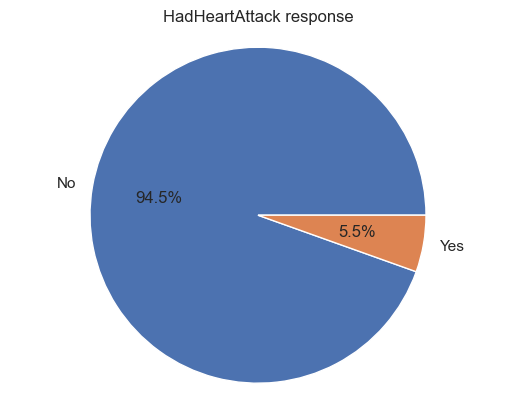

In [143]:
# print(df['HadHeartAttack'].value_counts())
heart_attack_count = df['HadHeartAttack'].value_counts()
print(heart_attack_count['No'])
print(heart_attack_count['Yes'])

labels = ['No', 'Yes']
values = [heart_attack_count['No'], heart_attack_count['Yes']] 
fig, ax = plt.subplots()

# Plot the pie chart
ax.pie(values, labels=labels, autopct='%1.1f%%')
ax.axis('equal')

# Add a title
ax.set_title('HadHeartAttack response')

# Show the plot
plt.show()

<div class="alert alert-block alert-warning">  
<b>Observation:</b> 
We notice that there is a significant class imbalance for <b>HadHeartAttack</b> here. For every ~24 rows, there will be one Yes. If we used the dataset as it is, then it will be significantly skewed towards 'No'. There will be poor performance on the minority class ('Yes') in this case. 

To fix this, we would downsample the amount of 'No's to the amount of 'Yes's, so that there is an equal amount. We would prefer to not do the alternative, to upsample the 'Yes', should be done with caution as is the nature of the dataset here (medical).

We also observe that there is sufficient rows of 'Yes's that we can use, even after we downsample (13k rows each is sufficient). We will have ~26k rows to work with and we bleieve that will be enough for this.
</div>

<h1 align="center"><font color='Blue'>Data exploration</font></h1>

Given so many variables, the immediate task is to find out which variables are the most meaningful and contribute to the final response (HadHeartAttack). We want to sieve out what's useful and what's not.

In [144]:
numeric = df.select_dtypes(include = ['int', 'float'])
categorical = df.select_dtypes(include = ['object'])

numeric.set_index(df.index)
numeric['HadHeartAttack'] = df['HadHeartAttack']

le = LabelEncoder()
numeric['HadHeartAttack'] = le.fit_transform(df['HadHeartAttack'])

print(numeric.head())

   PhysicalHealthDays  MentalHealthDays  SleepHours  HeightInMeters  \
0                 4.0               0.0         9.0            1.60   
1                 0.0               0.0         6.0            1.78   
2                 0.0               0.0         8.0            1.85   
3                 5.0               0.0         9.0            1.70   
4                 3.0              15.0         5.0            1.55   

   WeightInKilograms    BMI  HadHeartAttack  
0              71.67  27.99               0  
1              95.25  30.13               0  
2             108.86  31.66               0  
3              90.72  31.32               0  
4              79.38  33.07               0  


<h3 align="center"><font color='Green'>Numerical Data Analysis</font></h3>

 We first begin with numerical data analysis


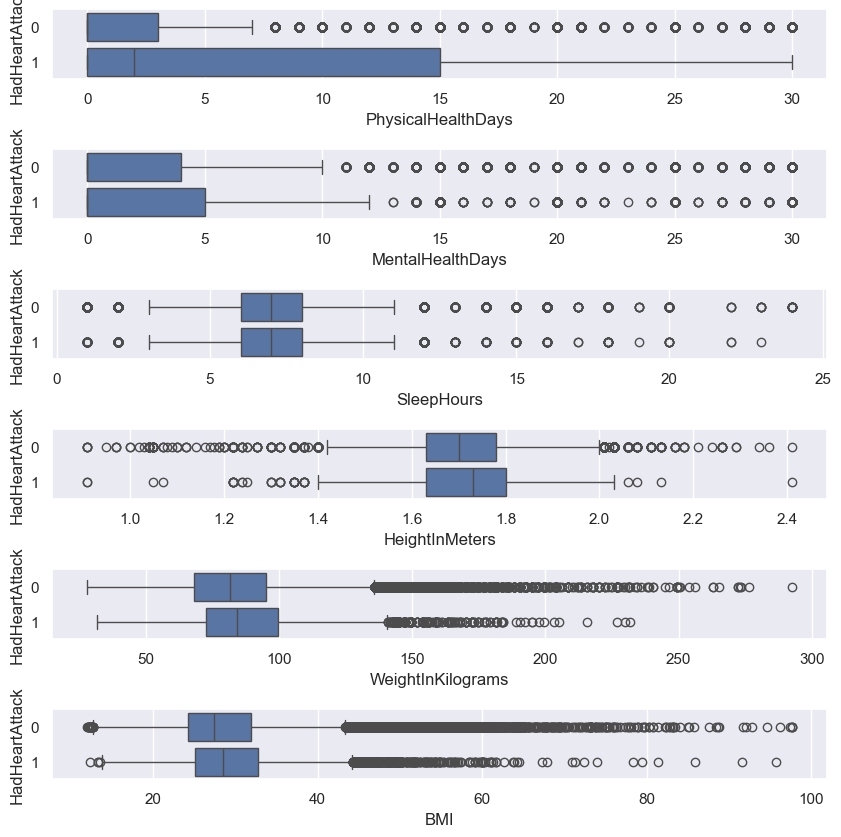

In [145]:
# Draw the distributions of all variables
f, axes = plt.subplots(6, 1, figsize=(10, 10), gridspec_kw={'hspace': 1})
f.subplots_adjust(hspace=0.3, wspace=0.3)

numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI' ]
for i, column in enumerate(numerical_columns):
    sb.boxplot(data = numeric, y='HadHeartAttack', x=column, orient = "h", ax = axes[i], showfliers = True)

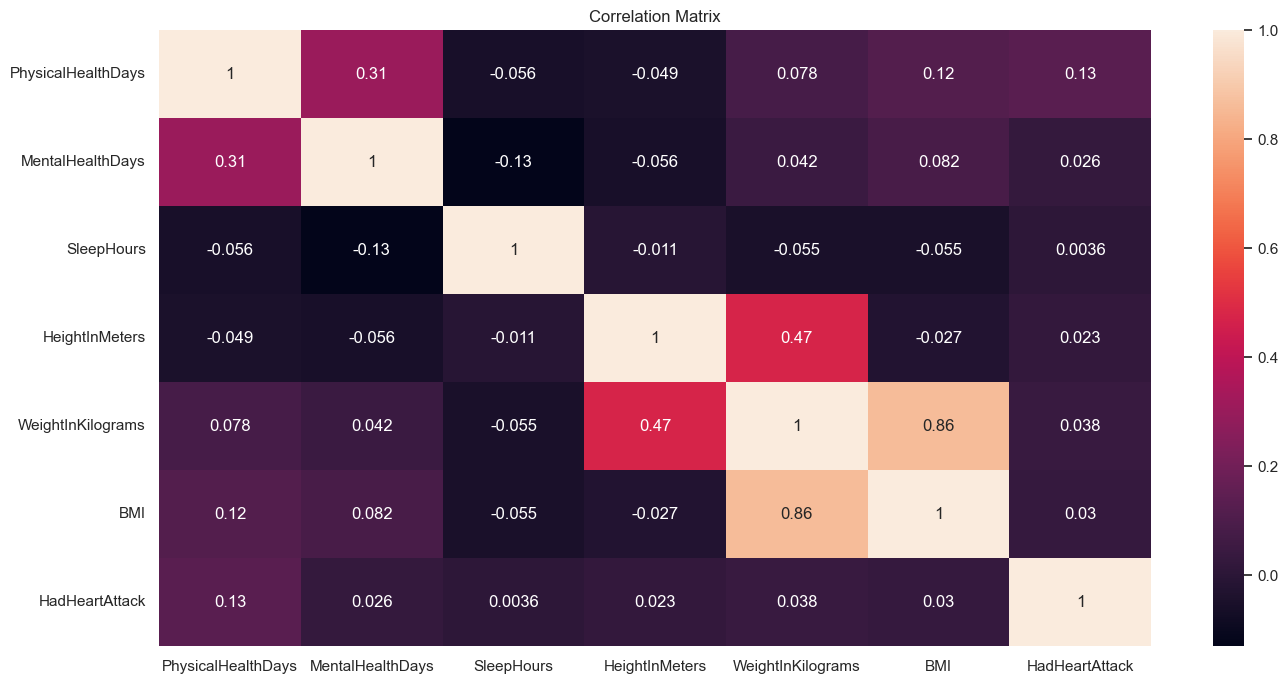

In [146]:
corr_matrix = numeric.corr()
plt.figure(figsize=(16, 8))
plt.title('Correlation Matrix')
sb.heatmap(corr_matrix, annot=True)
plt.show()

A correlation matrix with all the numeric categories. We want to look at the `HadHeartAttack` column in particular. We see that most of the features have not much correlation. We see that PhysicalHealthDays is one that has, a slight correlation with HadHeartAttack. WHile the other features are close to neglibible. This is something that we can take note for in the future.

<div class="alert alert-block alert-warning">
<b>Observation:</b> From the distribution of numeric data in this dataset, there is no noticeable partition to help classification with the exeception of <b>PhysicalHealthDays</b>. We can consider dropping <b>BMI, WeightInKilograms, HeightInMeters, MentalHealthDays</b>
</div>

<h3 align="center"><font color='green'>Categorical Data Analysis</font></h3>

We want to check see which categorical variables are best at predicting if a person has some form of heart disease.

In [147]:
# We don't want to include the HadHeartAttack column here as we want to compare against it.
categorical_columns = [col for col in df if is_string_dtype(df[col]) 
                       and col != 'HadHeartAttack'
                       and col != 'State'] # State has too many columns to make any meaningful inference
print(len(categorical_columns), categorical_columns)

32 ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


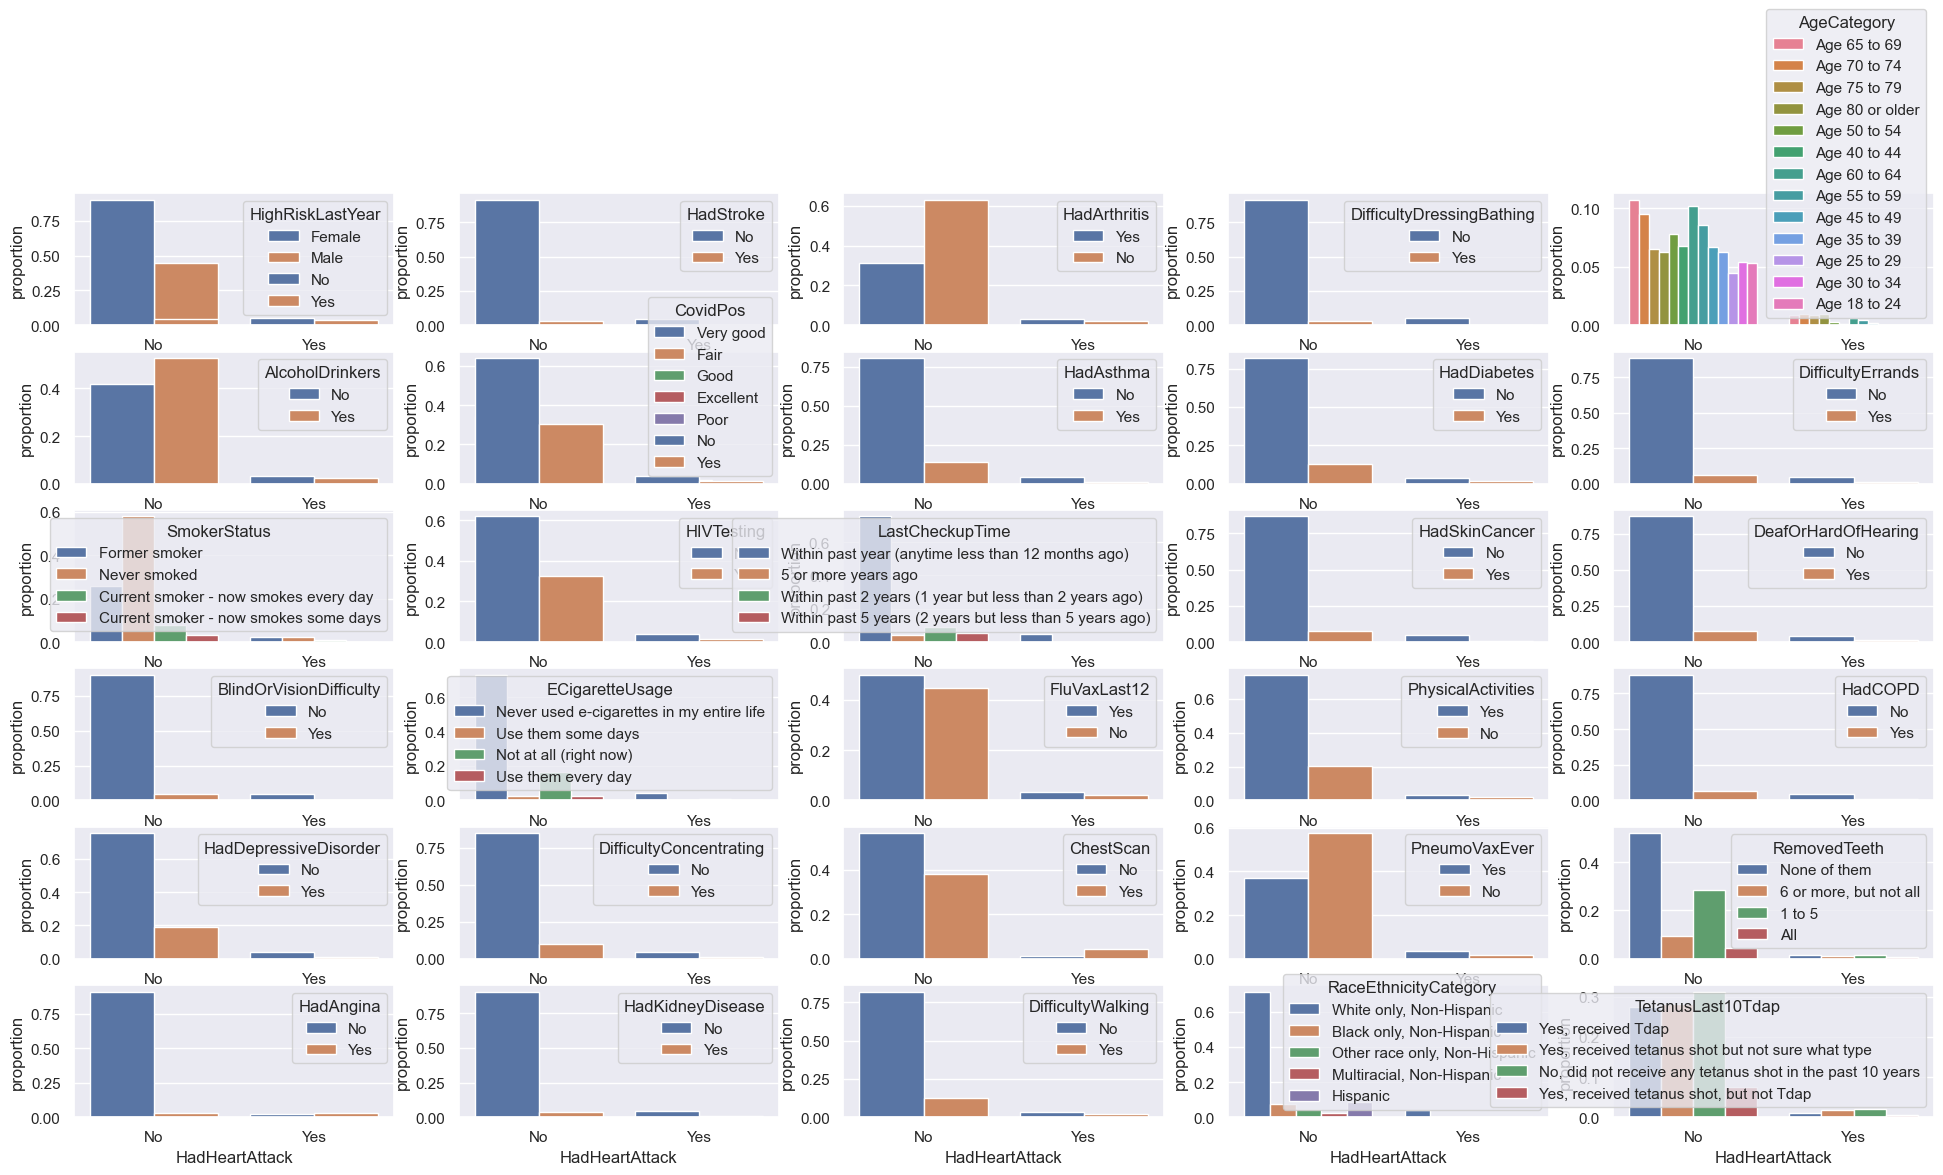

In [148]:
# 30 columns, so lets build 6x5 grid
f, axes = plt.subplots(6, 5, figsize=(24, 12))
for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    sb.countplot(pd.concat([df[col], df['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[r][c])

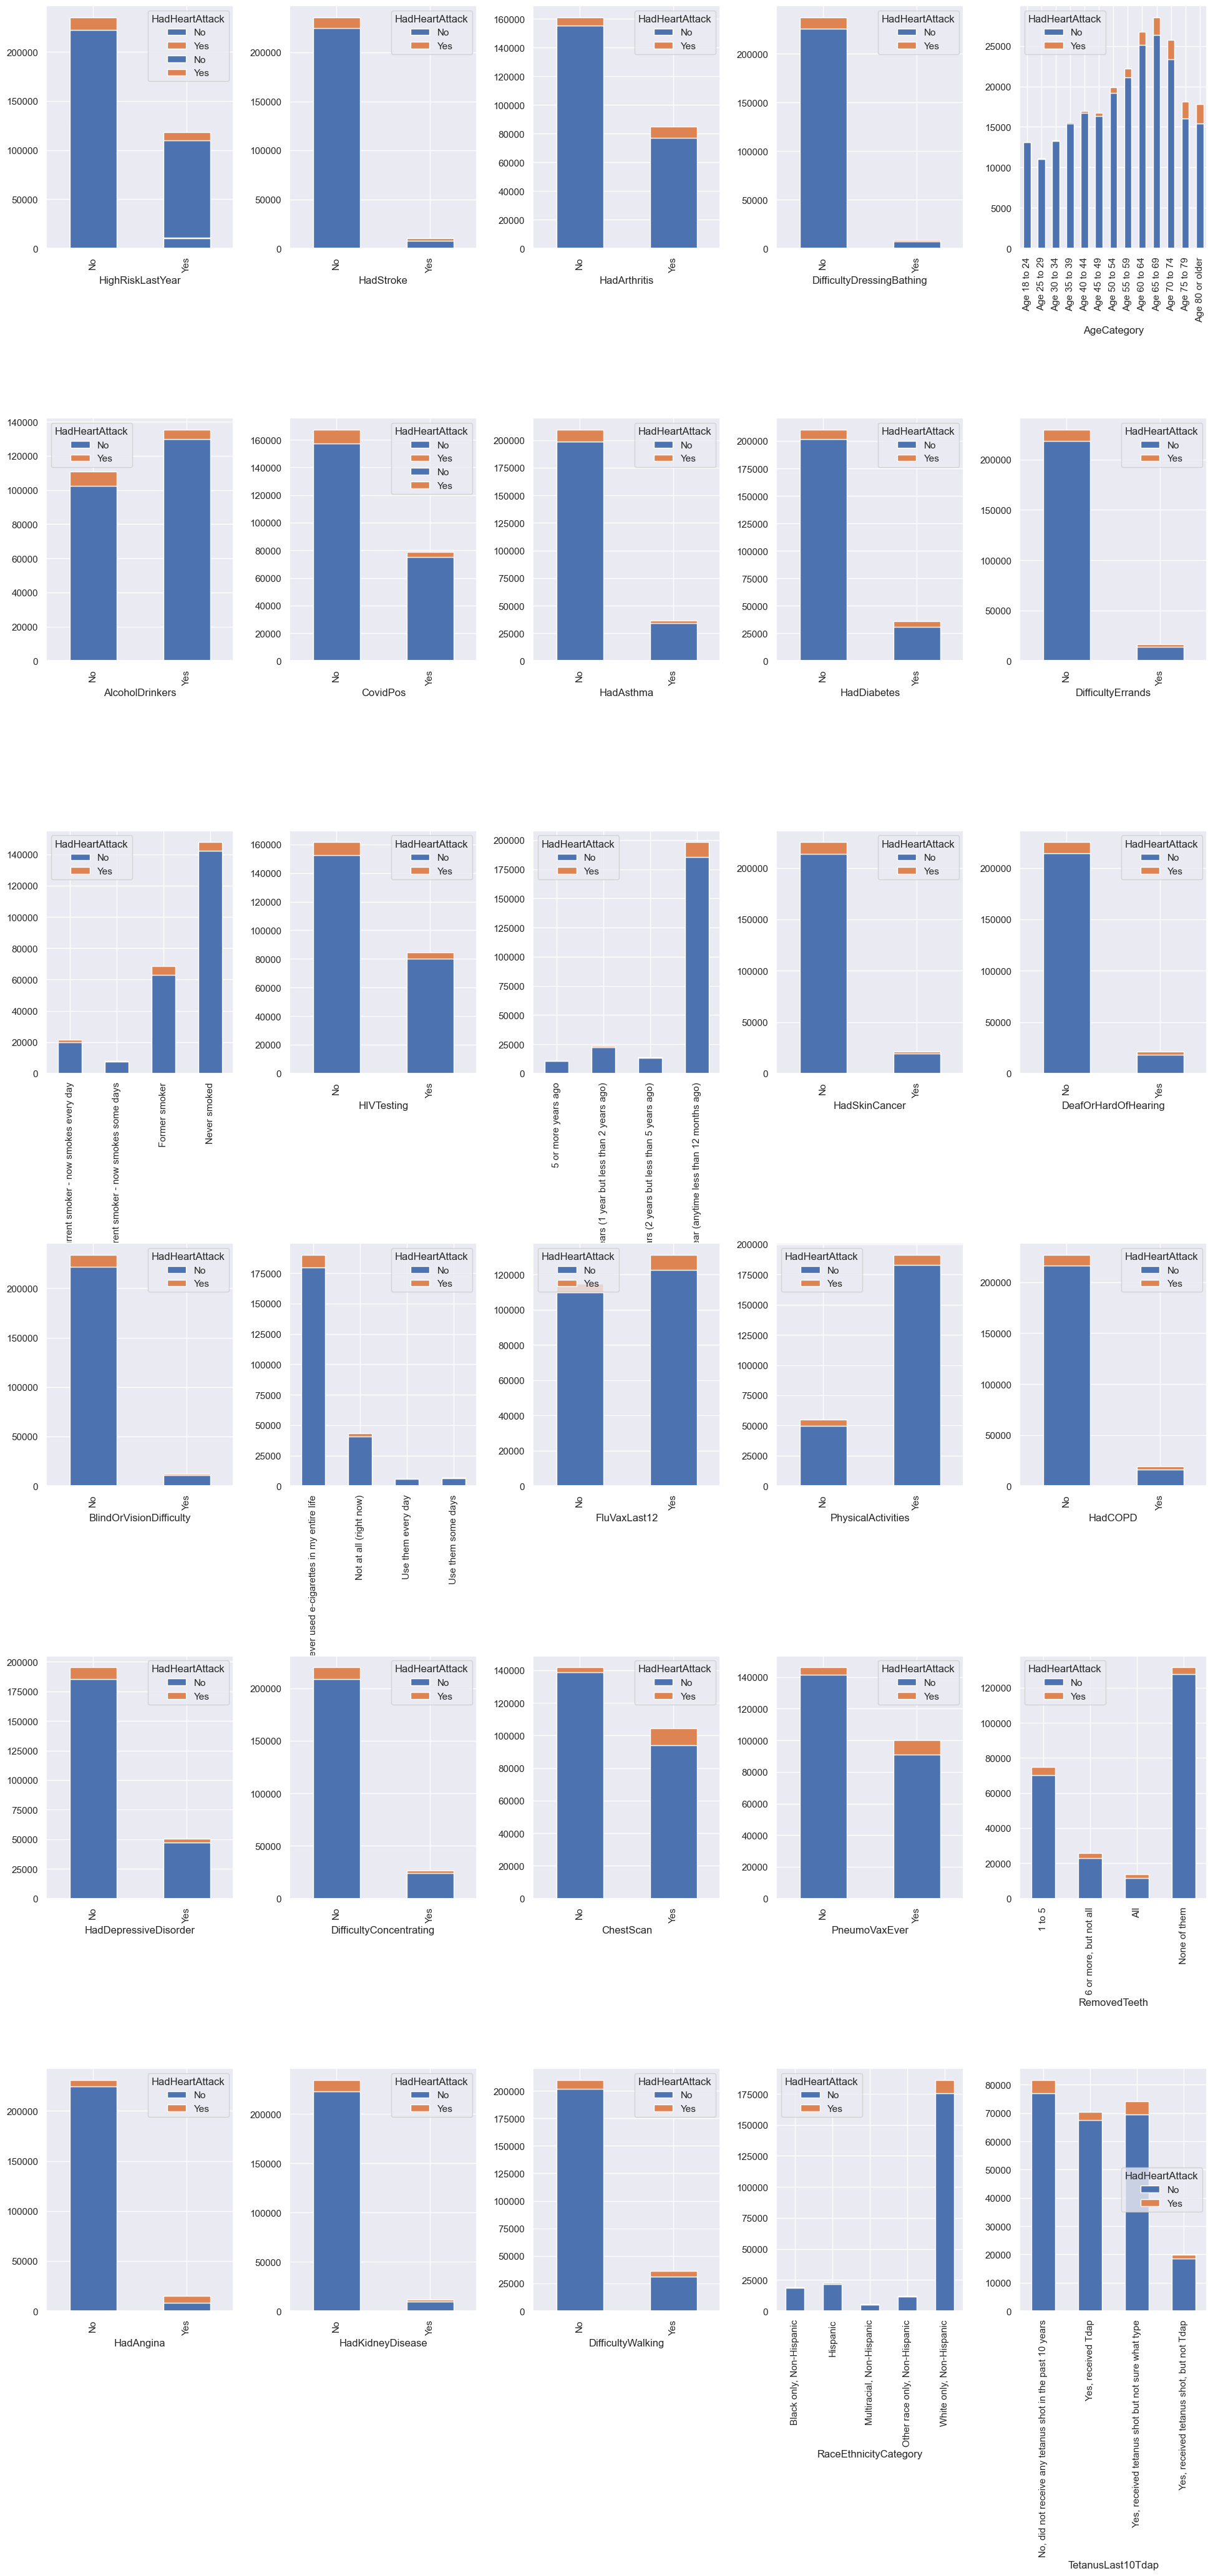

In [149]:
f, axes = plt.subplots(6, 5, figsize=(24, 48))
f.subplots_adjust(hspace=0.7, wspace=0.3)

for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    result= df.groupby(col)['HadHeartAttack'].value_counts().unstack()
    result.plot(kind='bar', stacked=True, ax=axes[r][c])

<div class="alert alert-block alert-warning">
    <b>Observation:</b> Based on obeservation alone, we can see some correlation between <b>AgeCategory, HadStroke, DifficultyDressingBathing, HadAngina.</b> We will keep these variables in mind. We can see the correlation in AgeCategory quite easily, where the older you get, the higher chances you will have a HeartAttack. While some of the other columns are tougher to see, we can still see that the proportion, as compared to the majority class is much higher.
</div>

There is a problem here, that there is too much data and it is insufficient to just look through each of them one by one to tell which are important. We need a more systematic manner to check and visualize. Hence, we will move onto preparing the data for feature selection.

### Under sampling the dataset


In [150]:
under = RandomUnderSampler()

df_under = df.copy()

x = df_under.drop(['HadHeartAttack'], axis=1)
y = df_under['HadHeartAttack']

x_under, y_under = under.fit_resample(x, y)
df_under = pd.concat([x_under, y_under], axis=1)

13435
13435


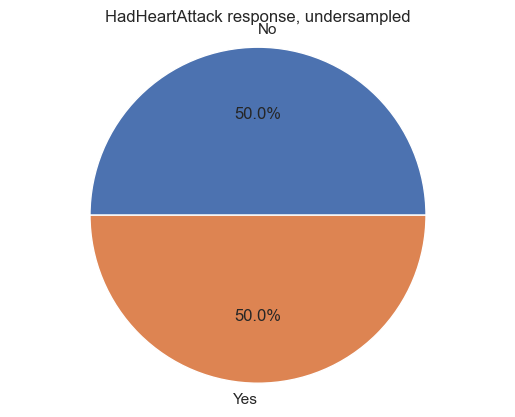

In [151]:
# print(df['HadHeartAttack'].value_counts())
heart_attack_count = df_under['HadHeartAttack'].value_counts()
print(heart_attack_count['No'])
print(heart_attack_count['Yes'])

labels = ['No', 'Yes']
values = [heart_attack_count['No'], heart_attack_count['Yes']] 
fig, ax = plt.subplots()

# Plot the pie chart
ax.pie(values, labels=labels, autopct='%1.1f%%')
ax.axis('equal')

# Add a title
ax.set_title('HadHeartAttack response, undersampled')

# Show the plot
plt.show()

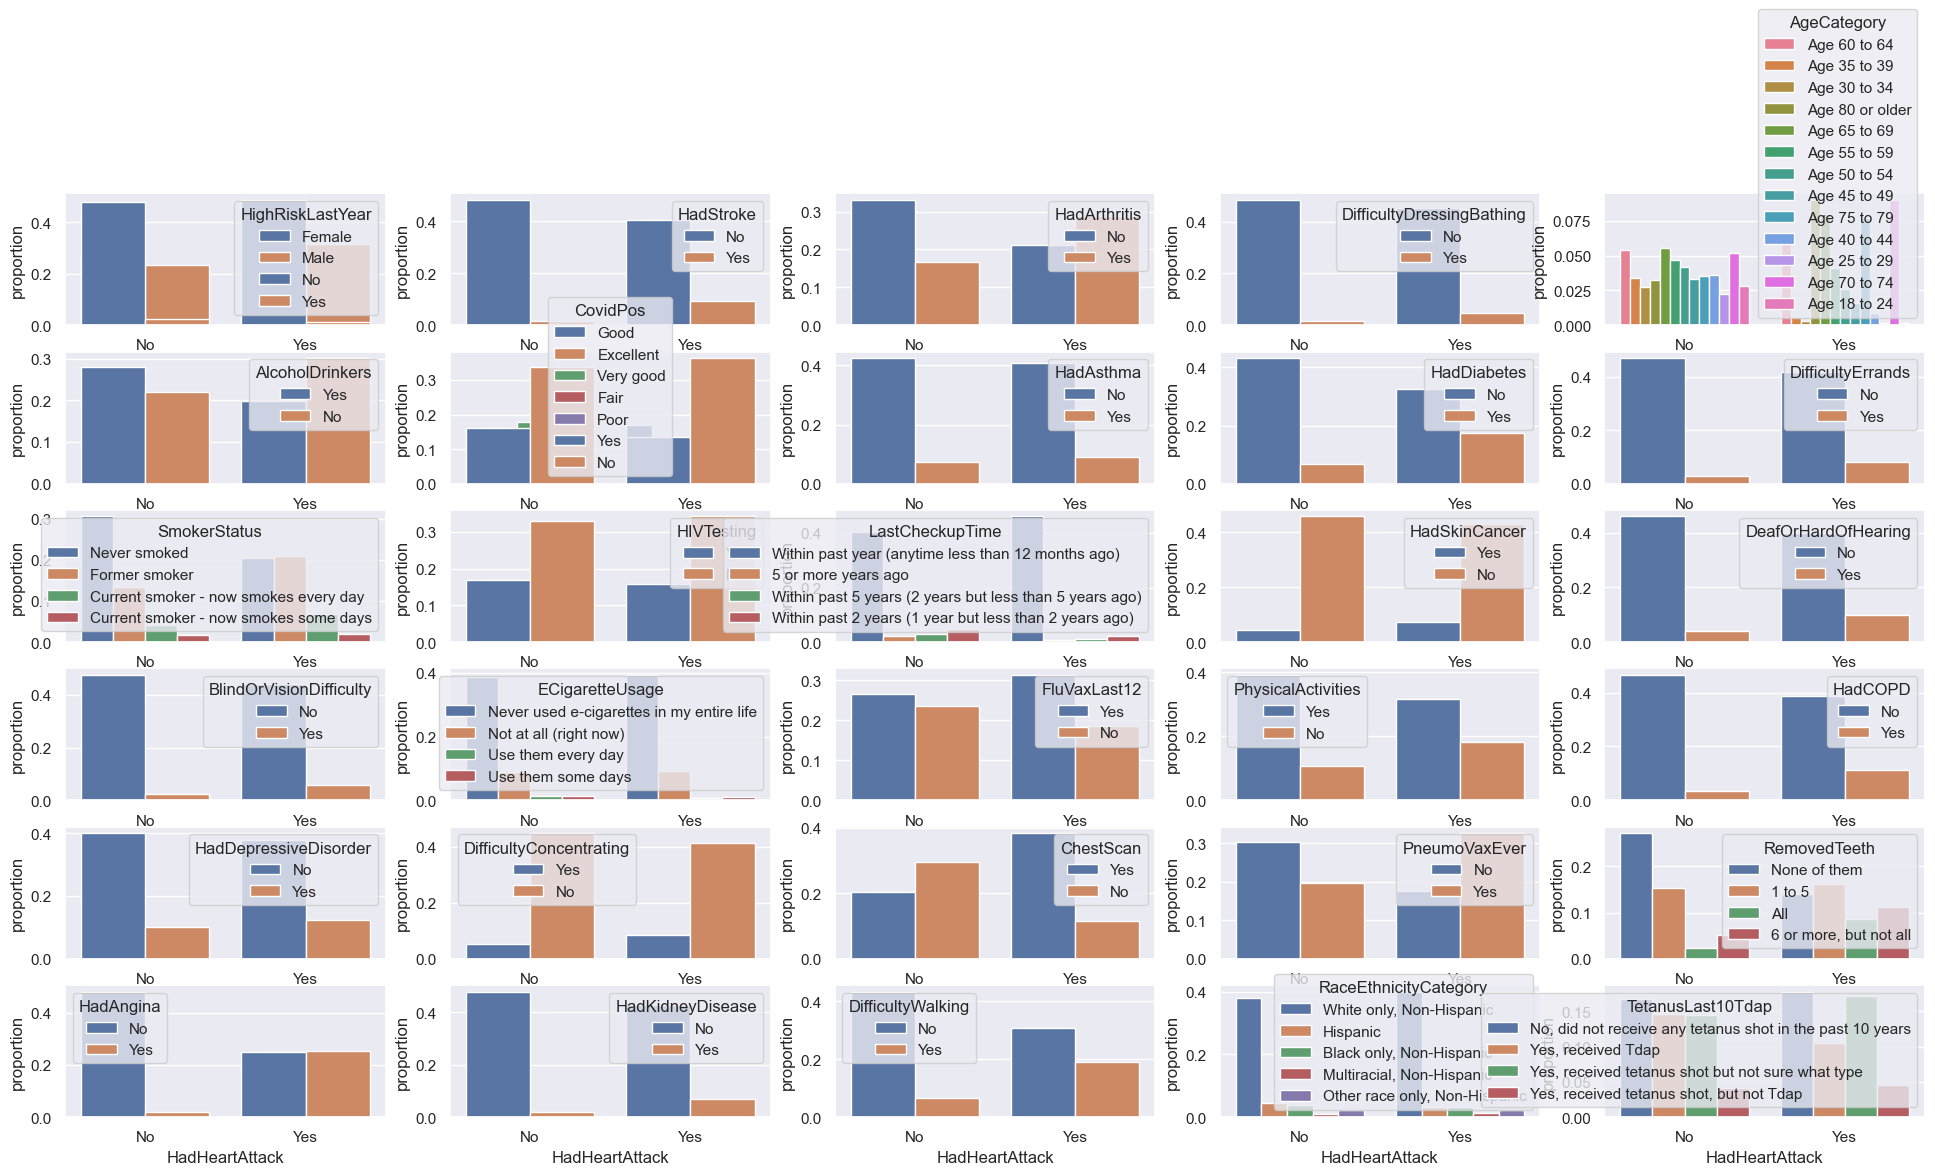

In [152]:
# 30 columns, so lets build 6x5 grid
f, axes = plt.subplots(6, 5, figsize=(24, 12))
for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    sb.countplot(pd.concat([df_under[col], df_under['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[r][c])

After we under-sampled the data to make the number of minority classes the same as the majority class, we can see some of the graphs clearer. For example, in the HadAngina graph, if you have do not have Angina, it is incredibly rare (abysmal even) that you have a HeartAttack. But if you have Angina, the chances of having a Heart Attack goes up **significantly**. This tells us that HadAngina is a very significant feature.

But even then, we would like to cut down on the features, some of them are still tough to tell.

## Prepare the data

We have a few goals in this section. We want to prepare the dataset such that it is best suited for the computer to read (i.e. numbers, not strings).

1. For columns which are boolean (True/False), we want to encode them as 1/0
2. For categorical columns which have a **relationship**  between the categorical outcomes, that naturally encode as a hierarchy, $a < b < c$, we want to use ordinal encoding for them
3. For categorical columns which **do not** have any relationships between each other, we want to one-hot encode them.

In [153]:
# Label Encode
def encode_df(df):
    # df_encode = df.copy()
    for column in df.columns:
        # If there are only two columns, we can label encode
        if (len(df[column].value_counts()) == 2):
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    
    # Ordinal encoding
    # Where the values in each of these categories have relavance to each other
    if 'GeneralHealth' in df:
        df['GeneralHealth'] = df['GeneralHealth'].replace({'Poor': 0,'Fair': 1,'Good': 2,'Very good': 3,'Excellent': 4})
    if 'SmokerStatus' in df:
        df['SmokerStatus'] = df['SmokerStatus'].replace({'Never smoked': 0,'Former smoker': 1,'Current smoker - now smokes some days': 2,'Current smoker - now smokes every day': 3})
    if 'AgeCategory' in df:
        df['AgeCategory'] = df['AgeCategory'].replace({'Age 18 to 24': 0,'Age 25 to 29': 1, 'Age 30 to 34': 2,'Age 35 to 39': 3,'Age 40 to 44': 4,'Age 45 to 49': 5,'Age 50 to 54': 6,'Age 55 to 59': 7,'Age 60 to 64': 8,'Age 65 to 69': 9,'Age 70 to 74': 10,'Age 75 to 79': 11,'Age 80 or older': 12})
    if 'ECigaretteUsage' in df:
        df['ECigaretteUsage'] = df['ECigaretteUsage'].replace({'Never used e-cigarettes in my entire life': 0,'Not at all (right now)': 1,'Use them some days': 2,'Use them every day': 3})
    if 'TetanusLast10Tdap' in df:
        df['TetanusLast10Tdap'] = df['TetanusLast10Tdap'].replace({'Yes, received Tdap': 0, 'Yes, received tetanus shot but not sure what type': 1, 'No, did not receive any tetanus shot in the past 10 years': 2, 'Yes, received tetanus shot, but not Tdap': 3})

    # One hot encode the rest of the columns
    df = pd.get_dummies(df)

    return df

In [154]:
df_encoded = encode_df(df.copy())

/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_24747/3023529726.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['GeneralHealth'] = df['GeneralHealth'].replace({'Poor': 0,'Fair': 1,'Good': 2,'Very good': 3,'Excellent': 4})
/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_24747/3023529726.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['SmokerStatus'] = df['SmokerStatus'].replace({'Never smoked': 0,'Former smoker': 1,'Current smoker - now smokes some days': 2,'Current smoker - now smokes every d

## Feature selection

Given that this dataset has a lot of columns, we want to do some feature selection. We have visualized from above, while some categories are promising, it is still rather difficult to eyeball. Here, we want to feature select the top 10 features, and check how useful the features are.

# Chi Square Test

**Reasons for use:**

- wanted to verify our observations from EDA to find important features
- able find relationships between categorical features and response
- robust to outliers (extreme proportions)
- non parametric (no assumption to distribution of data)

In [155]:
x = df_encoded.drop(['HadHeartAttack'], axis=1)
y = df_encoded['HadHeartAttack']

n_features = 10
selector = SelectKBest(chi2, k=n_features)
x_new = selector.fit_transform(x, y)

# Print out the top columns
mask = selector.get_support()
important_features = []
# Loop over the same columns that we train on
for b, val in zip(mask, x.columns):
    if b:
        important_features.append(val)

print(important_features)

['GeneralHealth', 'PhysicalHealthDays', 'HadAngina', 'HadStroke', 'HadCOPD', 'HadDiabetes', 'DifficultyWalking', 'ChestScan', 'AgeCategory', 'RemovedTeeth_All']


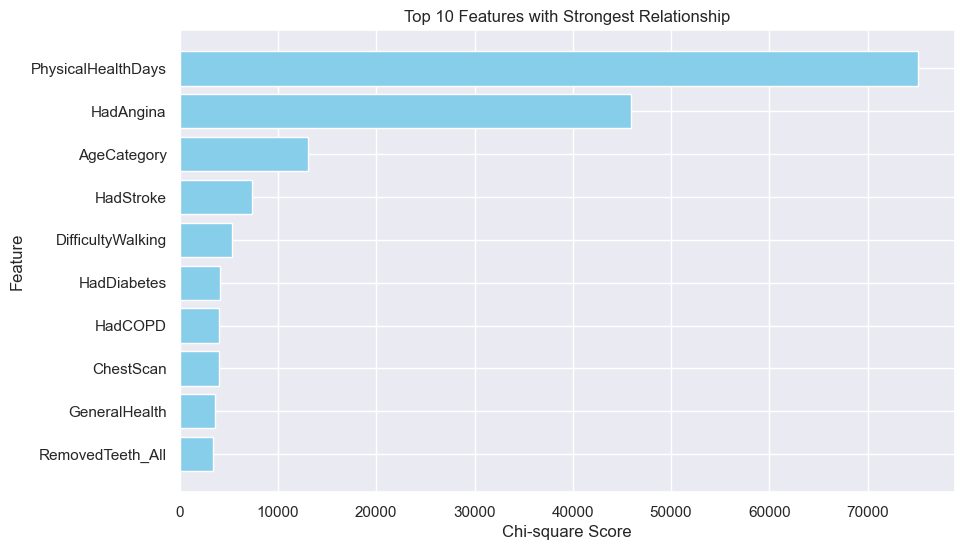

In [156]:
chi2_scores = selector.scores_
feature_names = x.columns
sorted_indices = np.argsort(chi2_scores)[::-1]  # Reverse order to get highest scores first
top_n_indices = sorted_indices[:n_features]
top_n_scores = chi2_scores[top_n_indices]
top_n_features = [feature_names[i] for i in top_n_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(np.arange(n_features), top_n_scores, color='skyblue')
plt.yticks(np.arange(n_features), top_n_features)
plt.title('Top {} Features with Strongest Relationship'.format(n_features))
plt.xlabel('Chi-square Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

We can see that in this dataset, there are around ~5 features that are very dominant in helping us predict HeartAttack. Following these 5, we have quite a few that are quite useful as well. But we see some diminishing returns towards the end. We will take the top 5 features.

In [157]:
# Filter out the one hot encoded titles
selected_n_features = 5
top_features = set([])
for feature in top_n_features[:selected_n_features]:
    for column in df:
        if column in feature:
            top_features.add(column)
top_features = list(top_features)

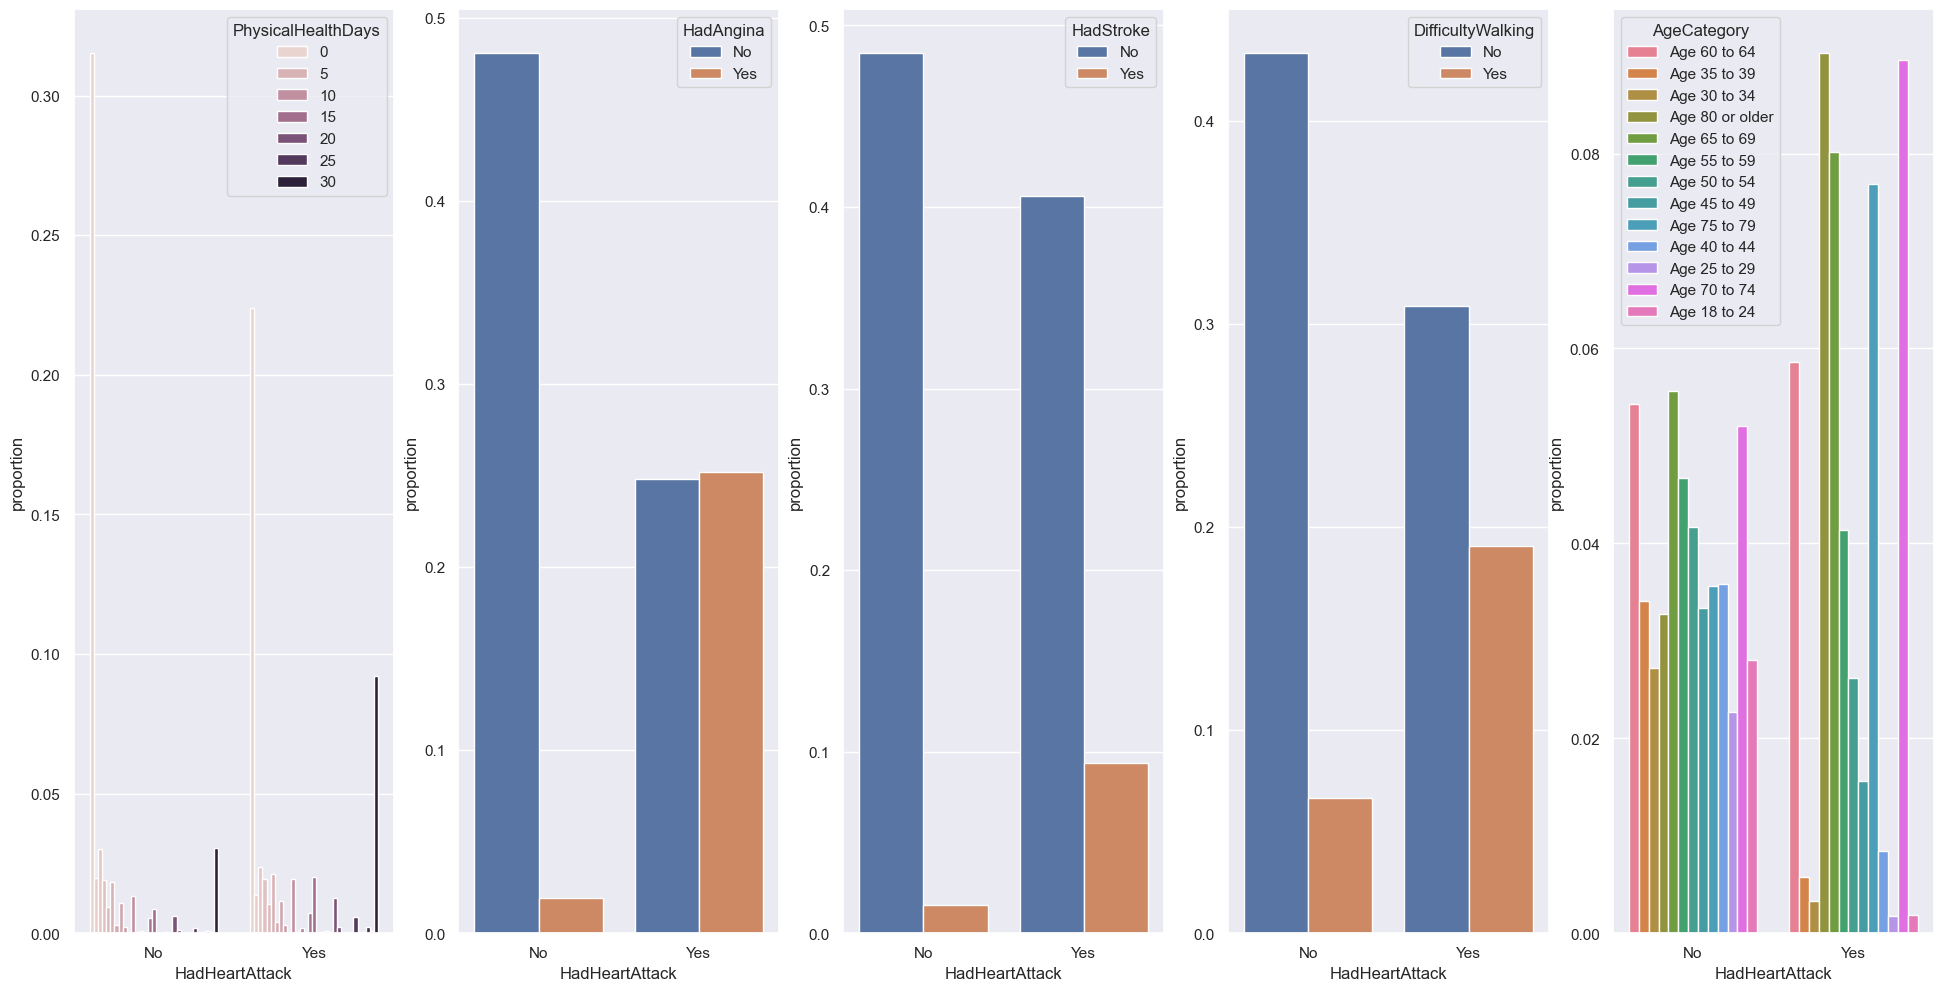

In [158]:
# 10 features, build 2x5 grid
f, axes = plt.subplots(1,5, figsize=(24, 12))
for i, col in enumerate(top_features):
    sb.countplot(pd.concat([df_under[col], df_under['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[i])

Now that we have removed the features that do not contribute to out feature analysis, we can look at inspect the graph again. We further confirm that these are features that are very important. We will drop the other features and only use these features from now on.

In [159]:
# Drop the all except these columns
df = df[top_features + ['HadHeartAttack']]

In [160]:
print(df.head())

   PhysicalHealthDays HadAngina HadStroke DifficultyWalking      AgeCategory  \
0                 4.0        No        No                No     Age 65 to 69   
1                 0.0        No        No                No     Age 70 to 74   
2                 0.0        No        No               Yes     Age 75 to 79   
3                 5.0        No        No               Yes  Age 80 or older   
4                 3.0        No        No                No  Age 80 or older   

  HadHeartAttack  
0             No  
1             No  
2             No  
3             No  
4             No  


<h1 align="center"><font color='Blue'>Modeling</font></h1>



In [161]:
# We want to use the data that is shuffled outside
# Don't mix shuffling of data into training the model
# All models should share the same set of shuffled data, and if the shuffled
# data should be changed, then we can reuse it again
def train_model(x_train, y_train, model):
    model.fit(x_train, y_train)
    return model

def evaluate_model(x_train, x_test, y_train, y_test, model, cv):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    score = cross_val_score(model, x_train, y_train, cv=cv)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # print(classification_report(y_test, model.predict(x_test)))
    
    print("Train accuracy : ", model.score(x_train, y_train))
    print("Train MSE: ", mean_squared_error(y_train, y_train_pred), '\n')
    
    print("Test accuracy : ", model.score(x_test, y_test))
    print("Test MSE: ", mean_squared_error(y_test, y_test_pred), '\n')

    print("Number of folds: ", cv)
    print("Accuracy score (Cross Validated):", score.mean())
    print("Standard Deviation (Cross Validated): ", ( score.std()), '\n')
    
    # Print the Accuracy Measures from the Confusion Matrix
    cmTrain = confusion_matrix(y_train, y_train_pred)
    tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
    fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
    print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
    print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)), '\n')
    
    cmTest = confusion_matrix(y_test, y_test_pred)
    tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
    fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
    print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
    print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
    print("FNR Test :\t", (fnTest/(tpTest + fnTest)), '\n')

    print("Acc : ", accuracy_score(y_test, y_test_pred))
    print("Precision :\t", precision)
    print("Recall :\t", recall)
    print("F1 score :\t", f1)

    f,axes = plt.subplots(1,2, figsize=(24,8))
    f.subplots_adjust(hspace=0.5, wspace=0.5)

    # Plot the two-way Confusion Matrix
    sb.heatmap(confusion_matrix(y_train, y_train_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
    axes[0].set_title('Confusion Matrix: Train Data', fontweight='bold', size =20)
    axes[0].set_xlabel('Predicted labels')
    axes[0].set_ylabel('True labels')
    axes[0].yaxis.set_ticklabels(['False', 'True'])
    axes[0].xaxis.set_ticklabels(['False', 'True'])
    
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])
    axes[1].set_title('Confusion Matrix: Test Data', fontweight = 'bold', size = 20)
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('True labels');
    axes[1].yaxis.set_ticklabels(['False', 'True'])
    axes[1].xaxis.set_ticklabels(['False', 'True'])
    
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


In [162]:
# Use the updated df that drops features that are not important
df_under = df.copy()
df_under = encode_df(df_under)

x = df_under.drop(['HadHeartAttack'], axis=1)
y = df_under['HadHeartAttack']

# x_under, y_under = under.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
x_train, y_train = under.fit_resample(x_train, y_train)

/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_24747/3023529726.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['AgeCategory'] = df['AgeCategory'].replace({'Age 18 to 24': 0,'Age 25 to 29': 1, 'Age 30 to 34': 2,'Age 35 to 39': 3,'Age 40 to 44': 4,'Age 45 to 49': 5,'Age 50 to 54': 6,'Age 55 to 59': 7,'Age 60 to 64': 8,'Age 65 to 69': 9,'Age 70 to 74': 10,'Age 75 to 79': 11,'Age 80 or older': 12})


# Decision Tree Model

**Reasons for trying this model:**
- Able to handle both numerical and categorical data
- Able to handle non linear relationships
- Able to show feature imporatance
- Robust to outliers

[Text(0.5, 0.875, 'HadAngina <= 0.5\ngini = 0.5\nsamples = 20154\nvalue = [10077, 10077]'),
 Text(0.25, 0.625, 'AgeCategory <= 6.5\ngini = 0.447\nsamples = 14726\nvalue = [9752, 4974]'),
 Text(0.125, 0.375, 'HadStroke <= 0.5\ngini = 0.256\nsamples = 5287\nvalue = [4490, 797]'),
 Text(0.0625, 0.125, 'gini = 0.227\nsamples = 5093\nvalue = [4427, 666]'),
 Text(0.1875, 0.125, 'gini = 0.439\nsamples = 194\nvalue = [63, 131]'),
 Text(0.375, 0.375, 'HadStroke <= 0.5\ngini = 0.493\nsamples = 9439\nvalue = [5262, 4177]'),
 Text(0.3125, 0.125, 'gini = 0.483\nsamples = 8538\nvalue = [5054, 3484]'),
 Text(0.4375, 0.125, 'gini = 0.355\nsamples = 901\nvalue = [208, 693]'),
 Text(0.75, 0.625, 'AgeCategory <= 3.5\ngini = 0.113\nsamples = 5428\nvalue = [325, 5103]'),
 Text(0.625, 0.375, 'HadStroke <= 0.5\ngini = 0.362\nsamples = 59\nvalue = [14, 45]'),
 Text(0.5625, 0.125, 'gini = 0.411\nsamples = 45\nvalue = [13.0, 32.0]'),
 Text(0.6875, 0.125, 'gini = 0.133\nsamples = 14\nvalue = [1, 13]'),
 Text(0.8

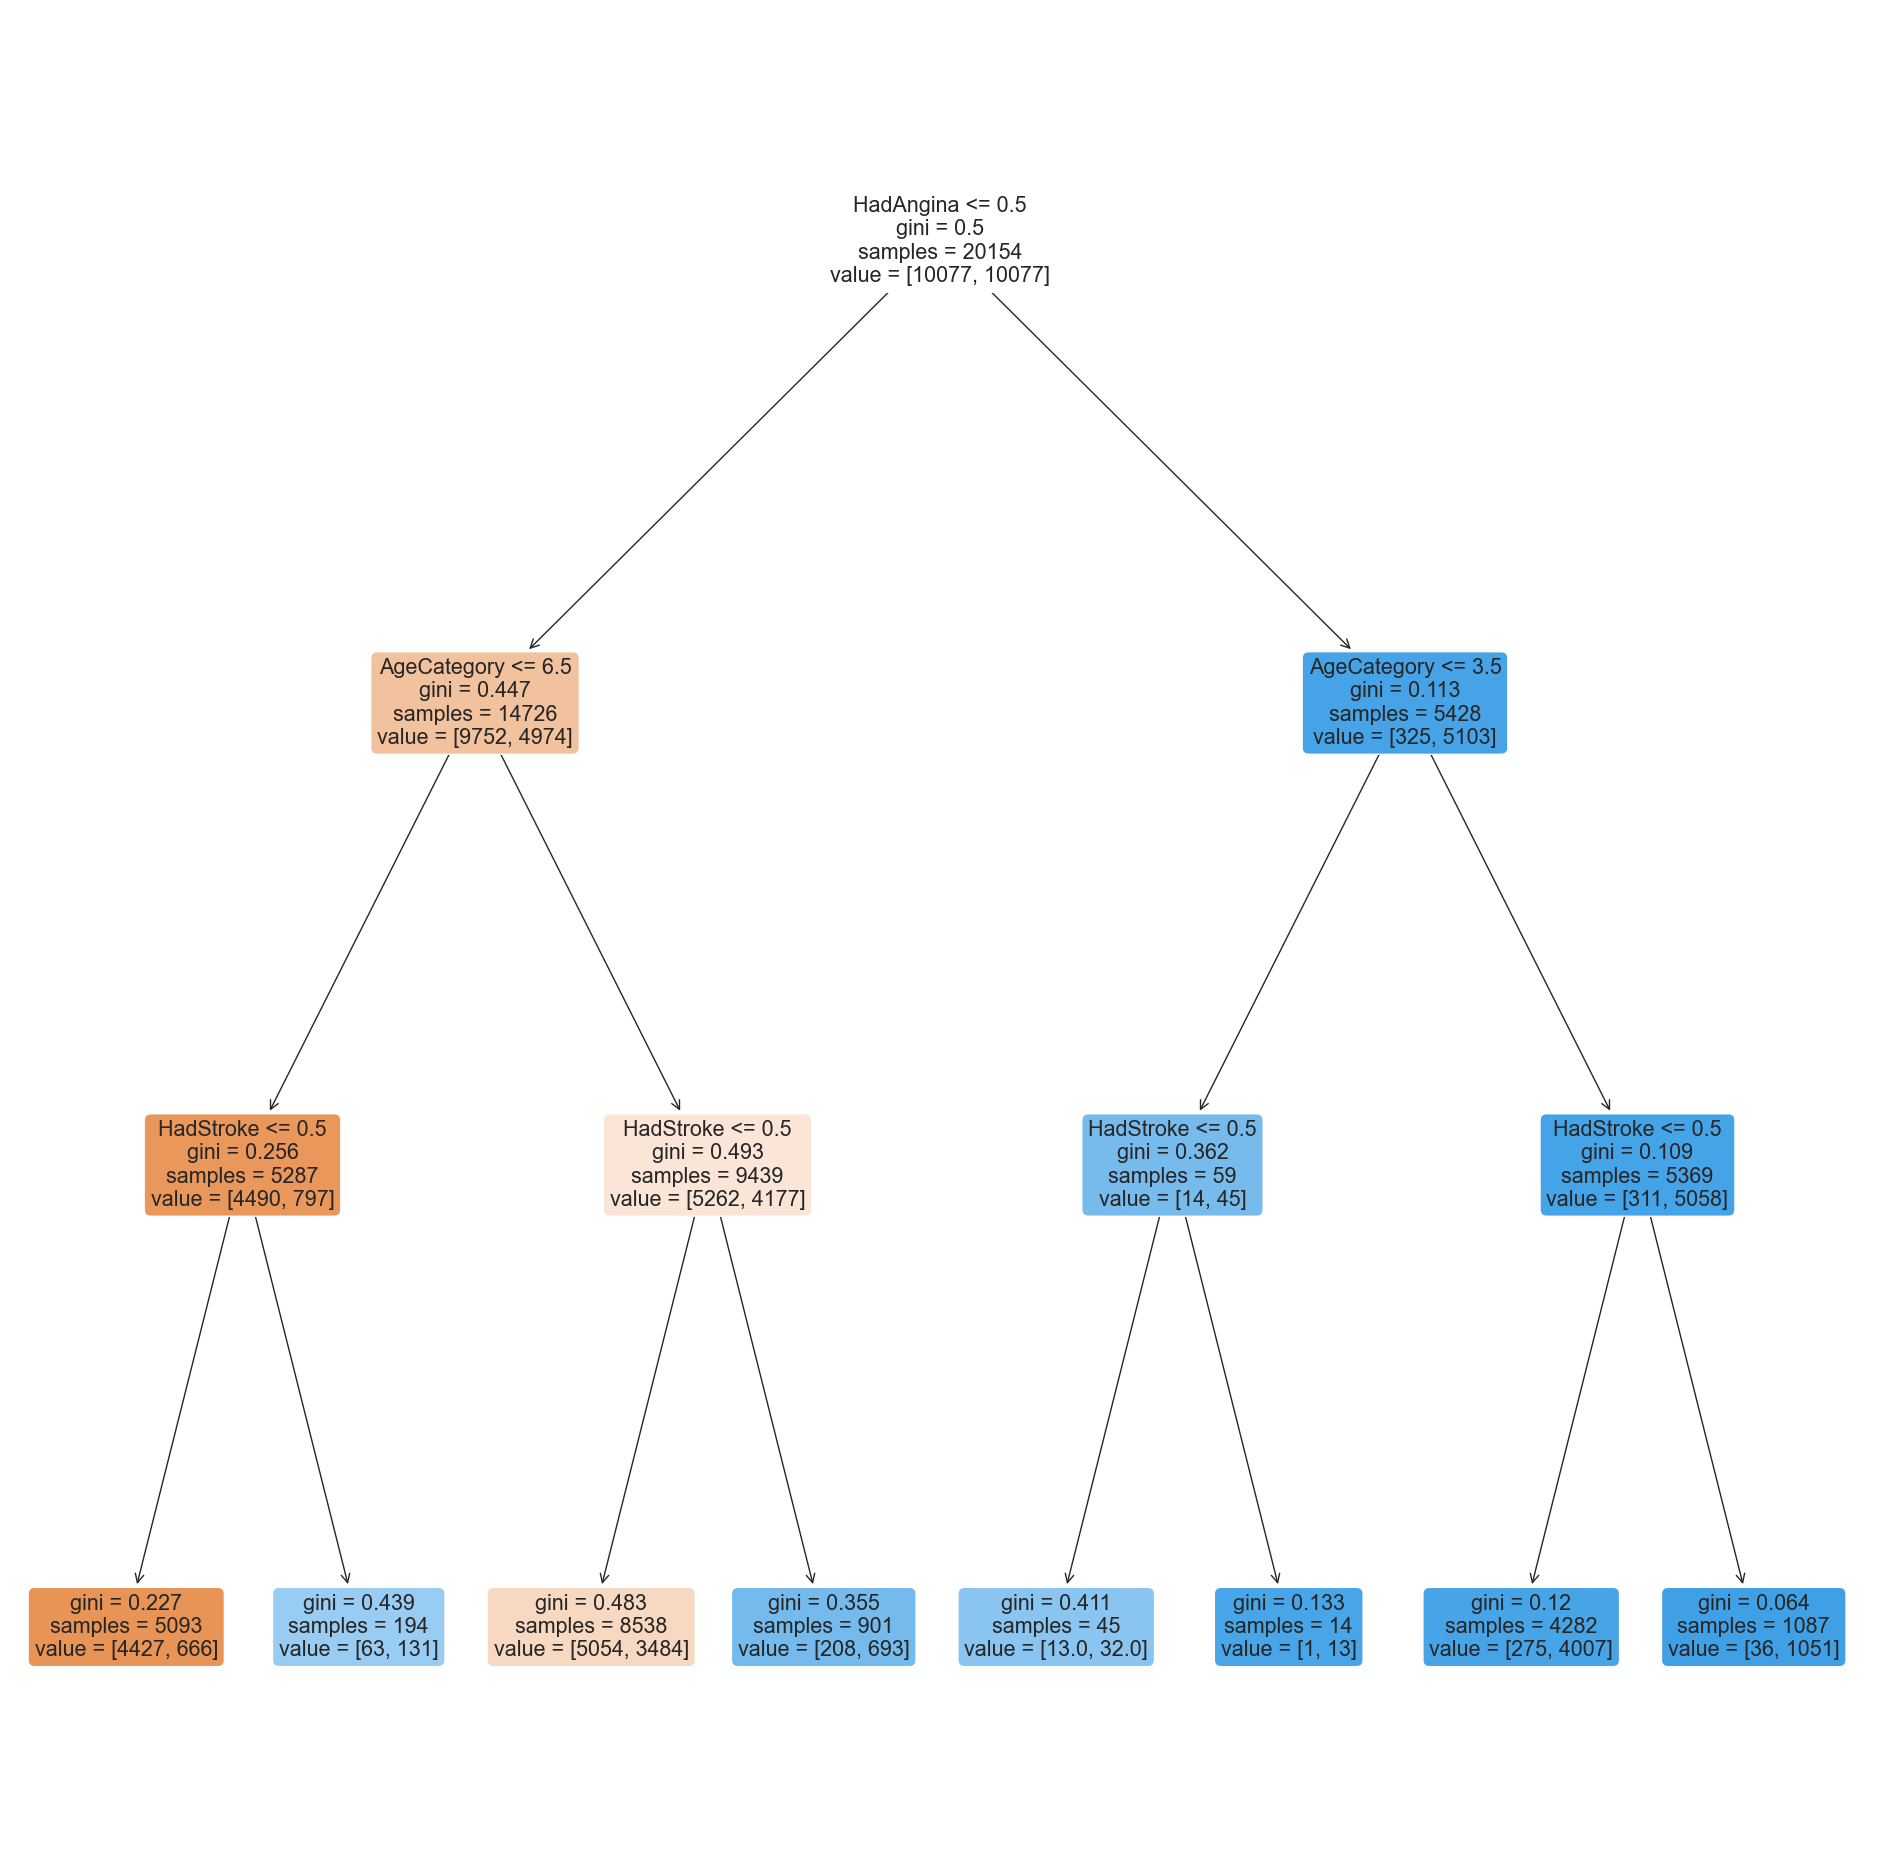

In [163]:
dectree = DecisionTreeClassifier(max_depth = 3)  # change max_depth to experiment
dectree.fit(x_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=x_train.columns.tolist())

Train accuracy :  0.7797955740795872
Train MSE:  0.2202044259204128 

Test accuracy :  0.8661593990830163
Test MSE:  0.13384060091698372 

Number of folds:  5
Accuracy score (Cross Validated): 0.7781581330298131
Standard Deviation (Cross Validated):  0.005232649528277061 

TPR Train :	 0.674010122060137
TNR Train :	 0.8855810260990374
FPR Train :	 0.11441897390096259
FNR Train :	 0.32598987793986306 

TPR Test :	 0.6685527099463967
TNR Test :	 0.8775710256586641
FPR Test :	 0.1224289743413359
FNR Test :	 0.33144729005360335 

Acc :  0.8661593990830163
Precision :	 0.23974797095258438
Recall :	 0.6685527099463967
F1 score :	 0.35293192894199027


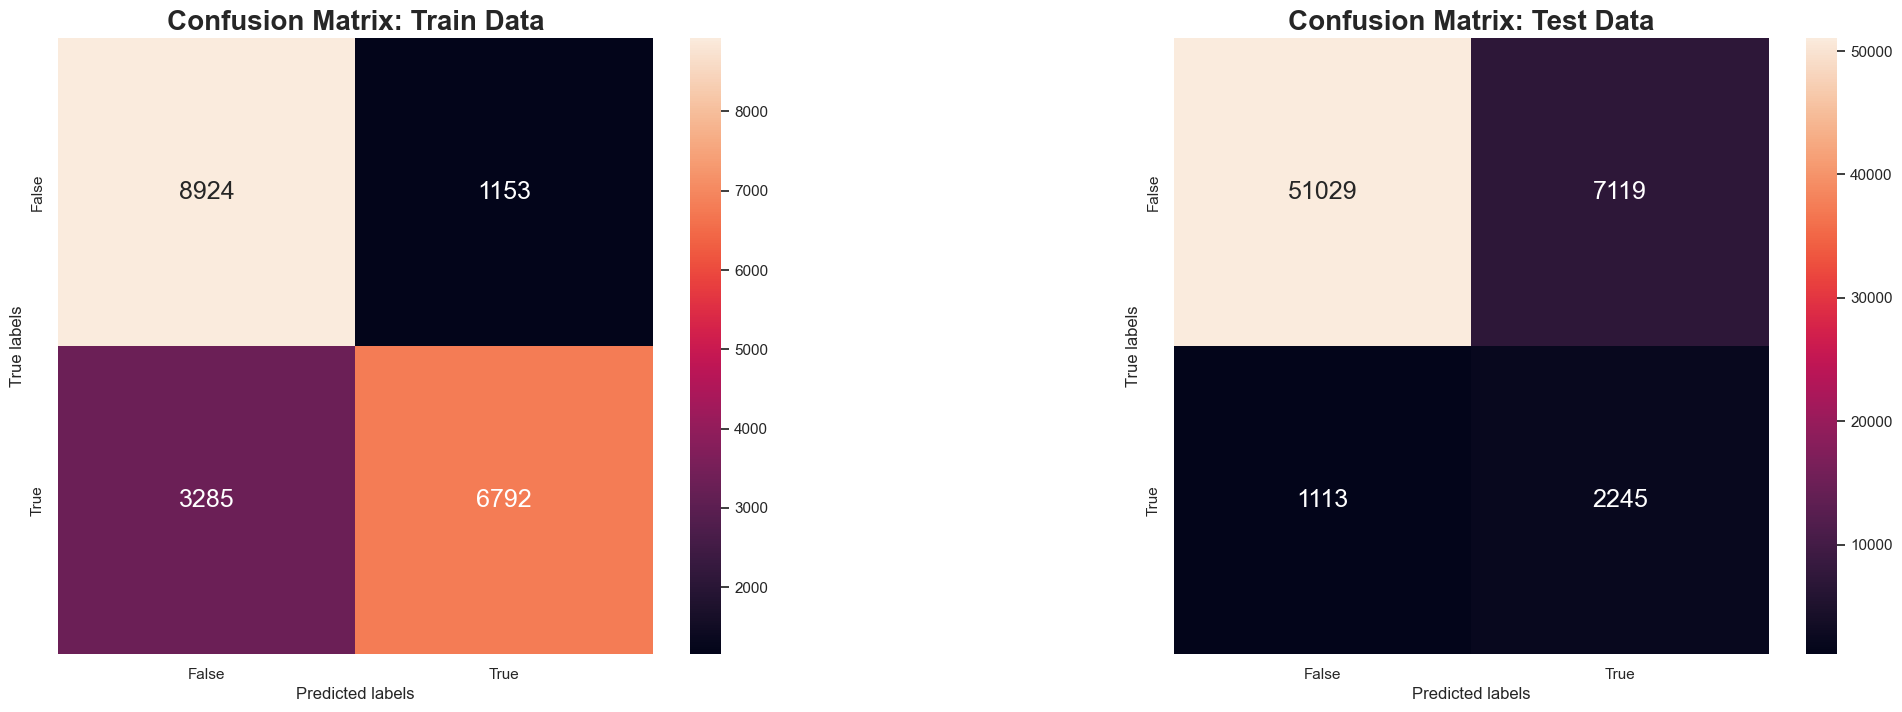

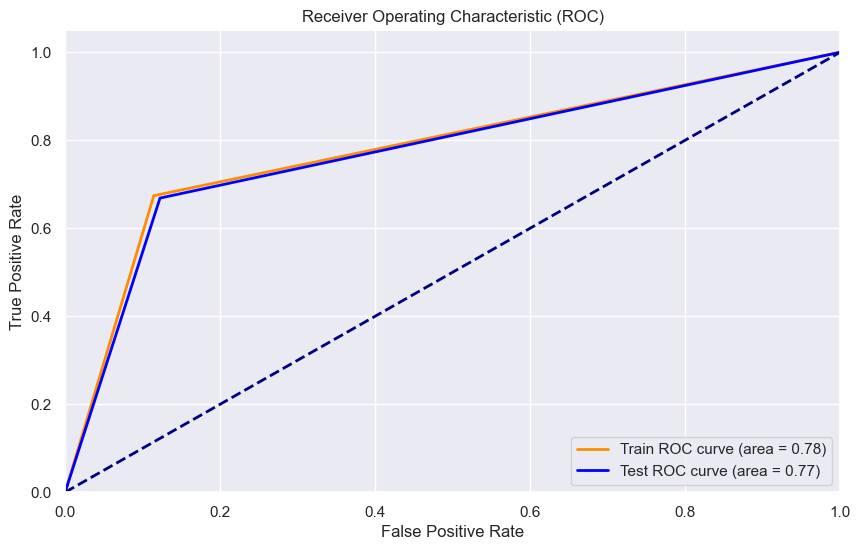

In [164]:
# Under sampled dataset
decision_tree_classifier = train_model(x_train, y_train, DecisionTreeClassifier(max_depth=5))
# evaluate_model(x_train, x_test, y_train, y_test, x_original, y_original, decision_tree_classifier, 5)
evaluate_model(x_train, x_test, y_train, y_test, decision_tree_classifier, 5)

# Random Forest

**Reasons for trying this model:**
- reduces overfitting by averaging multiple tree decisions
- can handle datasets with high-dimensional data
    - this can be useful in this dataset 
- automatic feature selection
    - on top of us manually feature selecting, this can help us further filter out

Train accuracy :  0.7958221692964176
Train MSE:  0.20417783070358242 

Test accuracy :  0.8440639937567067
Test MSE:  0.15593600624329335 

Number of folds:  5
Accuracy score (Cross Validated): 0.7750321115572675
Standard Deviation (Cross Validated):  0.003504735878649219 

TPR Train :	 0.7087426813535774
TNR Train :	 0.8829016572392577
FPR Train :	 0.11709834276074228
FNR Train :	 0.29125731864642257 

TPR Test :	 0.6810601548540798
TNR Test :	 0.8534773337002133
FPR Test :	 0.14652266629978675
FNR Test :	 0.31893984514592016 

Acc :  0.8440639937567067
Precision :	 0.21162209678911817
Recall :	 0.6810601548540798
F1 score :	 0.3229085774797035


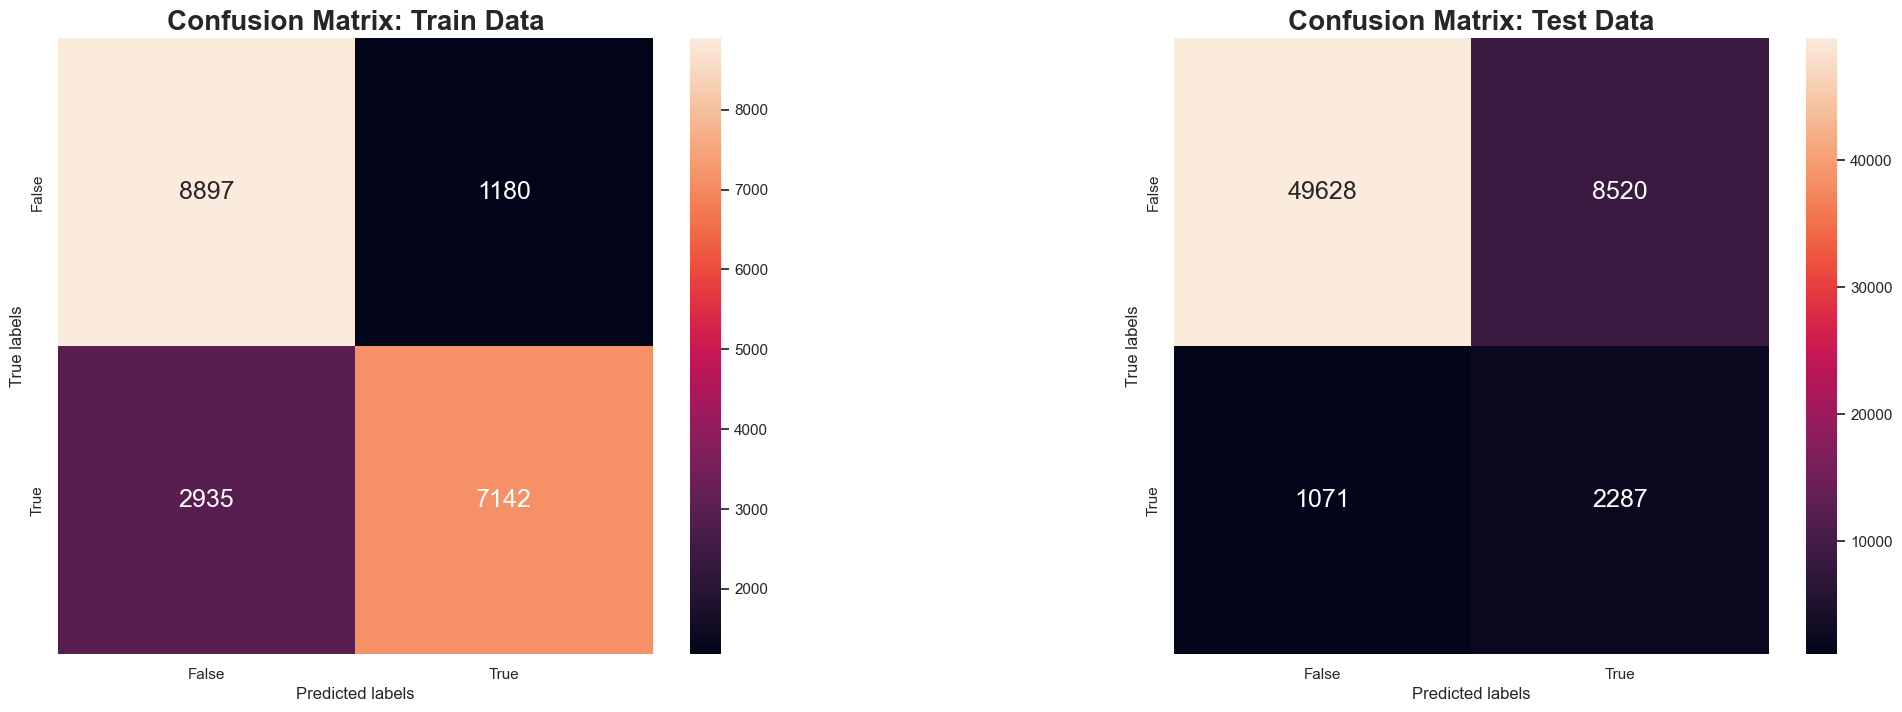

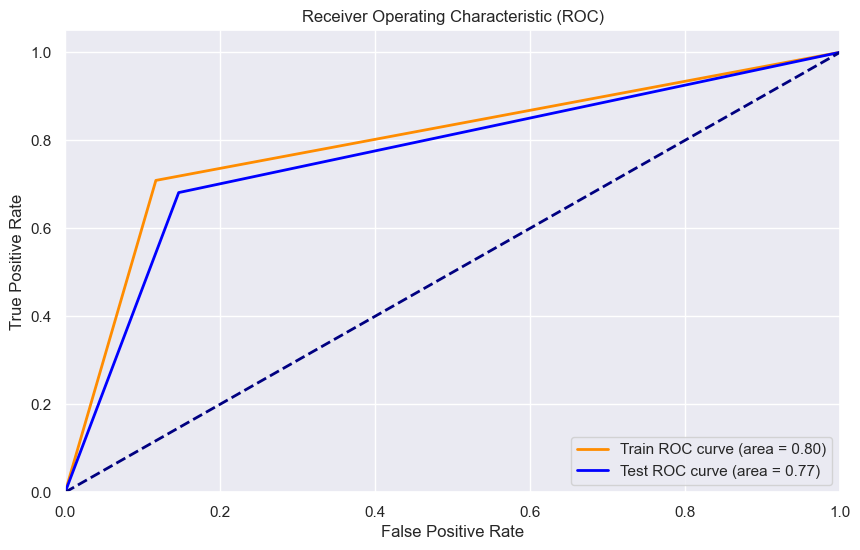

In [165]:
random_forest_classifier = train_model(x_train, y_train, RandomForestClassifier())
# evaluate_model(x_train, x_test, y_train, y_test, x_original, y_original, random_forest_classifier, 5)
evaluate_model(x_train, x_test, y_train, y_test, random_forest_classifier, 5)

# Logistic Regression Model

**Reasons for trying this model:**
- Good opportunity to check if our problem space is here rather linear
    - LogisticRegression performs well if the problem space can be modelled linearly, this let's us check if this is the case. Should it be the case, the LogisticRegression classifier will perform well.
- Robustness to Irrelevant Features
- Works Well with Linearly Separable Data
- Can Handle Both Numeric and Categorical Features

Train accuracy :  0.7805894611491515
Train MSE:  0.21941053885084846 

Test accuracy :  0.8579813351542939
Test MSE:  0.1420186648457061 

Number of folds:  5
Accuracy score (Cross Validated): 0.7797953946246613
Standard Deviation (Cross Validated):  0.004978495159241286 

TPR Train :	 0.6865138434057755
TNR Train :	 0.8746650788925275
FPR Train :	 0.12533492110747246
FNR Train :	 0.31348615659422446 

TPR Test :	 0.6834425253126861
TNR Test :	 0.8680608103460136
FPR Test :	 0.13193918965398638
FNR Test :	 0.3165574746873139 

Acc :  0.8579813351542939
Precision :	 0.2302598575298485
Recall :	 0.6834425253126861
F1 score :	 0.3444652908067542


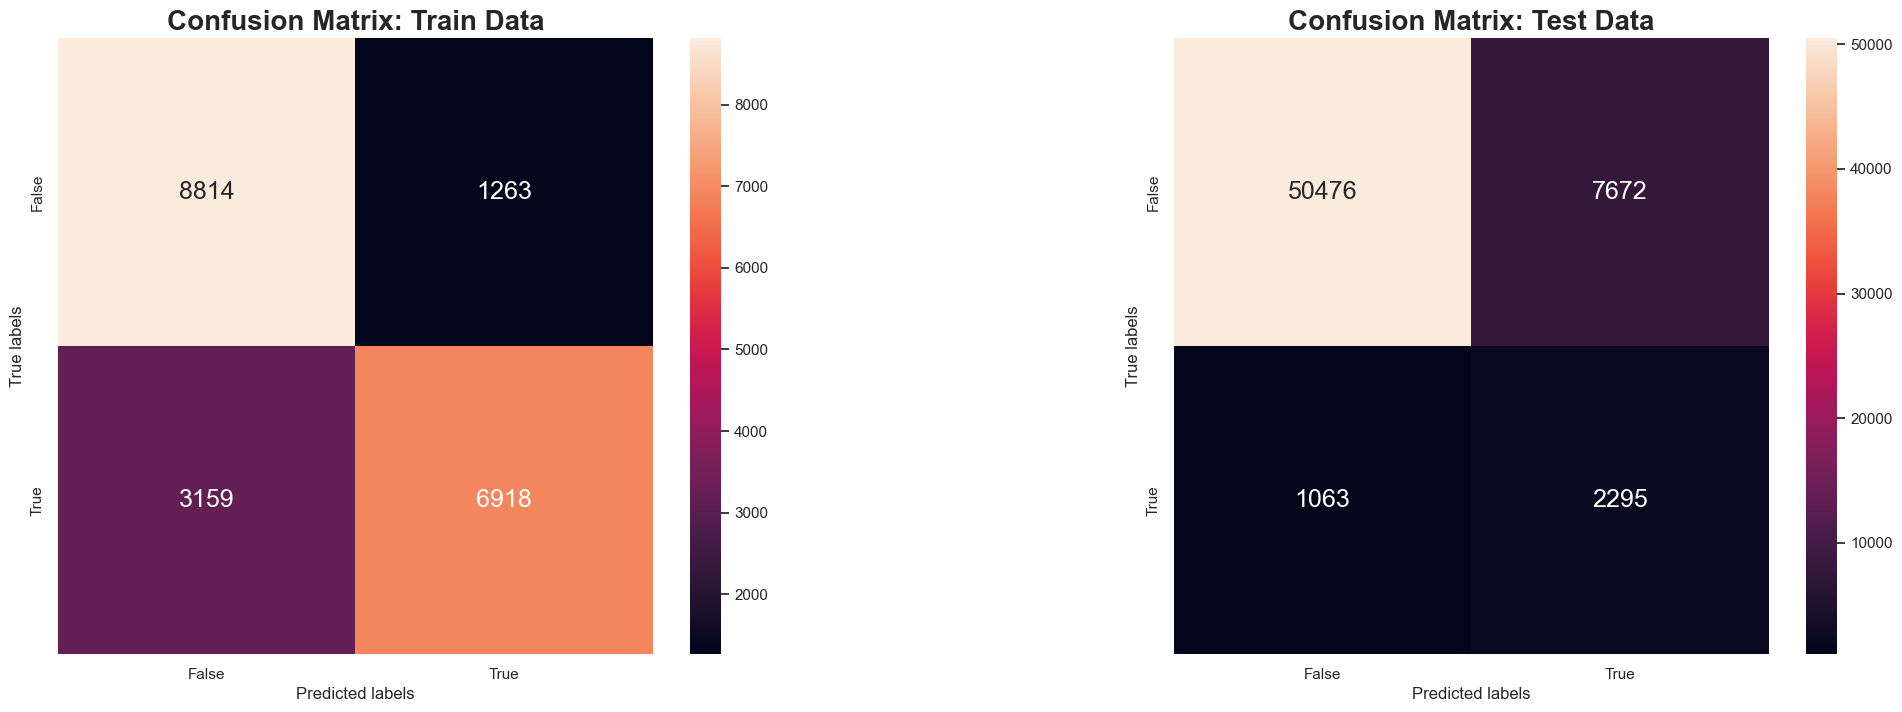

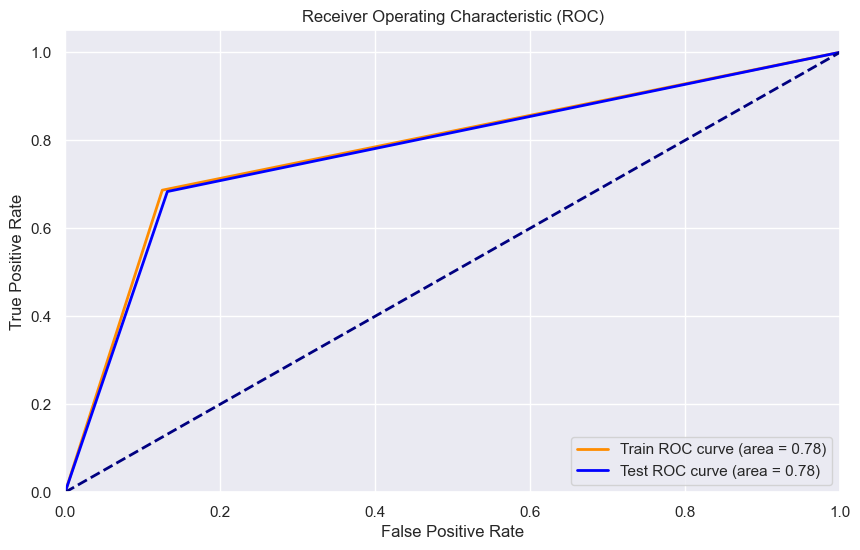

In [166]:
logistic_regression_classifier = train_model(x_train, y_train, LogisticRegression())
# evaluate_model(x_train, x_test, y_train, y_test, x_original, y_original, logistic_regression_classifier, 5)
evaluate_model(x_train, x_test, y_train, y_test, logistic_regression_classifier, 5)

We note that the the accuracy isn't very good. Although they all converge at around the same accuracy. We suspect that this is because of the under-sampled dataset. There are a few issues with an under-sampled dataset.

- Even though they have an equal number of classes for the model to learn from, there are a few drawbacks.
- It is that we are removing **a lot** of data from the majority class. In our case, if we do random under sampling, we will be removing more than 200,000 rows. There is a lot of data there that play a significant part into telling us that someone **does not** have heart disease.

We want to try to resample with SMOTEENN, a method that combines both oversampling and undersampling and is commonly used to resample datasets out there.

In [167]:
df_over_under = encode_df(df.copy())

over_under = SMOTEENN()

x = df_over_under.drop(['HadHeartAttack'], axis=1)
y = df_over_under['HadHeartAttack']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
x_train, y_train = over_under.fit_resample(x_train, y_train)

/var/folders/1h/n71pkykd6q509yz2cyyfsngr0000gn/T/ipykernel_24747/3023529726.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['AgeCategory'] = df['AgeCategory'].replace({'Age 18 to 24': 0,'Age 25 to 29': 1, 'Age 30 to 34': 2,'Age 35 to 39': 3,'Age 40 to 44': 4,'Age 45 to 49': 5,'Age 50 to 54': 6,'Age 55 to 59': 7,'Age 60 to 64': 8,'Age 65 to 69': 9,'Age 70 to 74': 10,'Age 75 to 79': 11,'Age 80 or older': 12})


Let's retrain the models above with a SMOTEENN resampled dataset

# Decision Tree (Resampled)

Train accuracy :  0.9493073105941818
Train MSE:  0.050692689405818225 

Test accuracy :  0.9367053620784964
Test MSE:  0.0632946379215036 

Number of folds:  5
Accuracy score (Cross Validated): 0.9492642520997687
Standard Deviation (Cross Validated):  0.0017528832960907257 

TPR Train :	 0.6602457002457003
TNR Train :	 0.9906520379260175
FPR Train :	 0.009347962073982443
FNR Train :	 0.33975429975429977 

TPR Test :	 0.46736526946107787
TNR Test :	 0.9636557439053742
FPR Test :	 0.03634425609462573
FNR Test :	 0.5326347305389222 

Acc :  0.9367053620784964
Precision :	 0.4247619047619048
Recall :	 0.46736526946107787
F1 score :	 0.4450463292943692


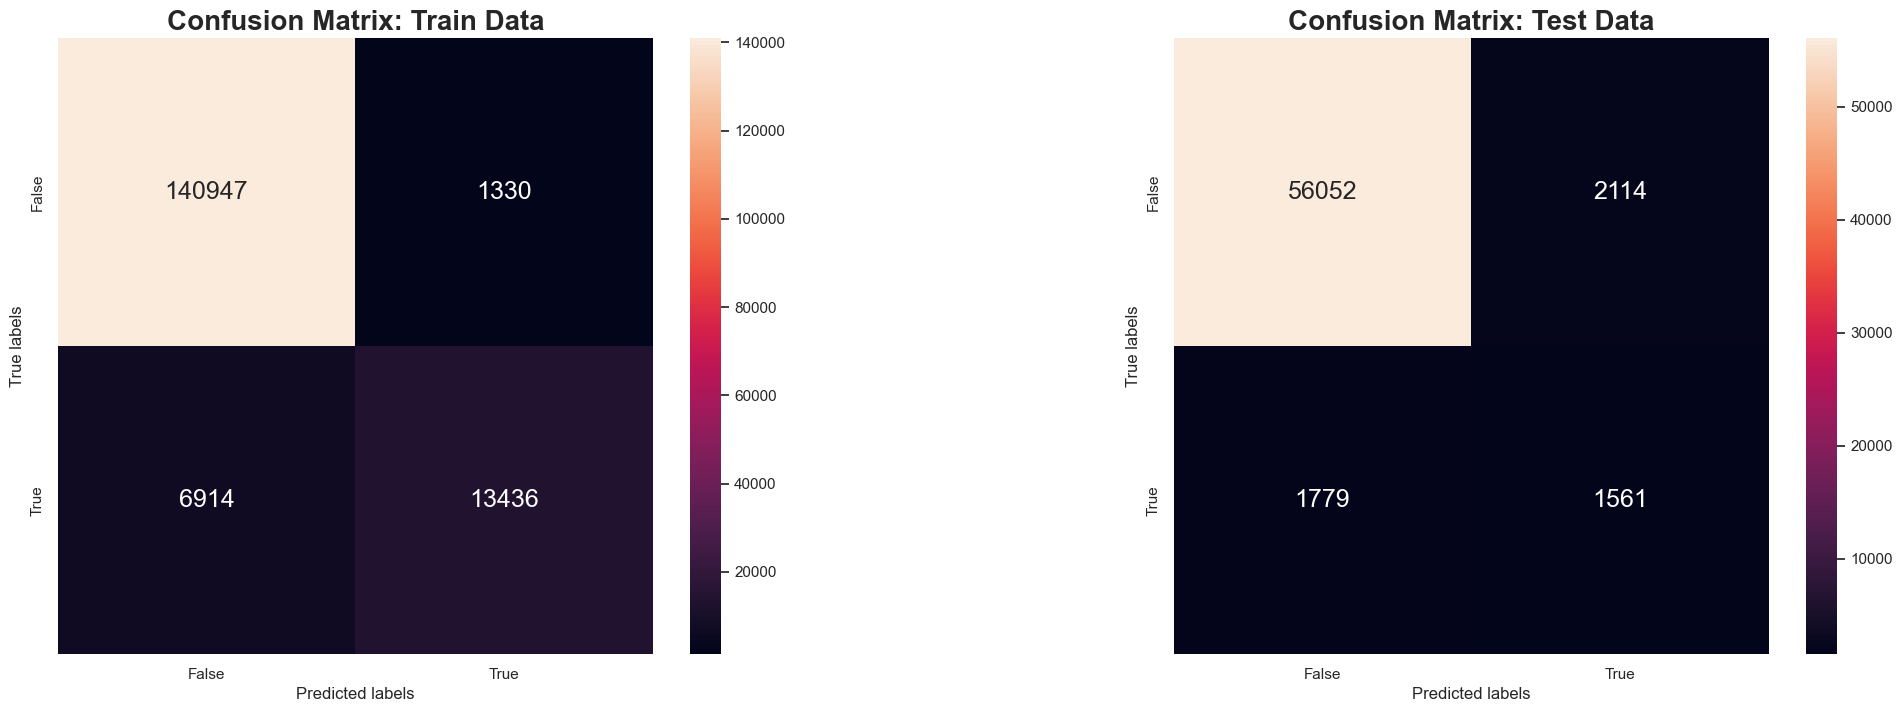

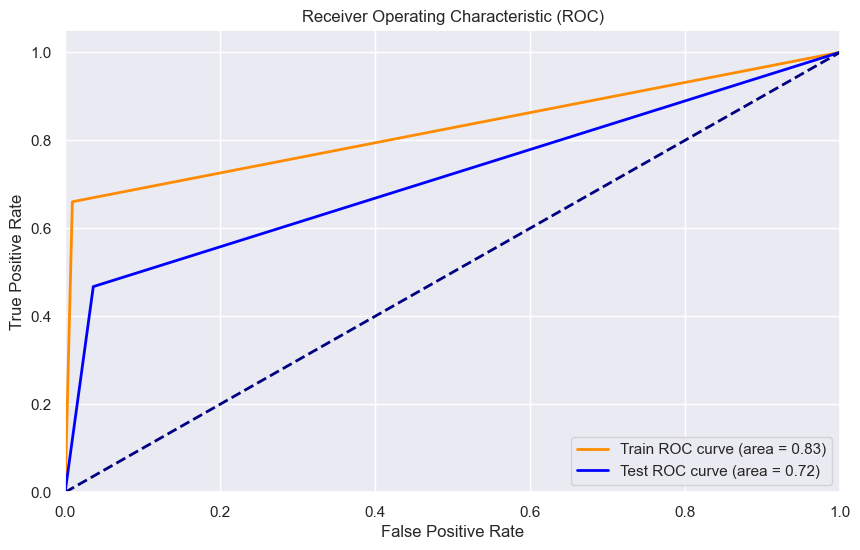

In [169]:
decision_tree_classifier = train_model(x_train, y_train, DecisionTreeClassifier(max_depth=5))
evaluate_model(x_train, x_test, y_train, y_test, decision_tree_classifier, 5)

# Random Forest (Resampled)

Train accuracy :  0.9732270779144915
Train MSE:  0.026772922085508556 

Test accuracy :  0.9067570643514454
Test MSE:  0.09324293564855461 

Number of folds:  5
Accuracy score (Cross Validated): 0.9714930387860232
Standard Deviation (Cross Validated):  0.001368458888878085 

TPR Train :	 0.827076167076167
TNR Train :	 0.9941311666678381
FPR Train :	 0.0058688333321619095
FNR Train :	 0.17292383292383293 

TPR Test :	 0.4425149700598802
TNR Test :	 0.933414709624179
FPR Test :	 0.06658529037582092
FNR Test :	 0.5574850299401197 

Acc :  0.9067570643514454
Precision :	 0.2762100541954775
Recall :	 0.4425149700598802
F1 score :	 0.34012196525140953


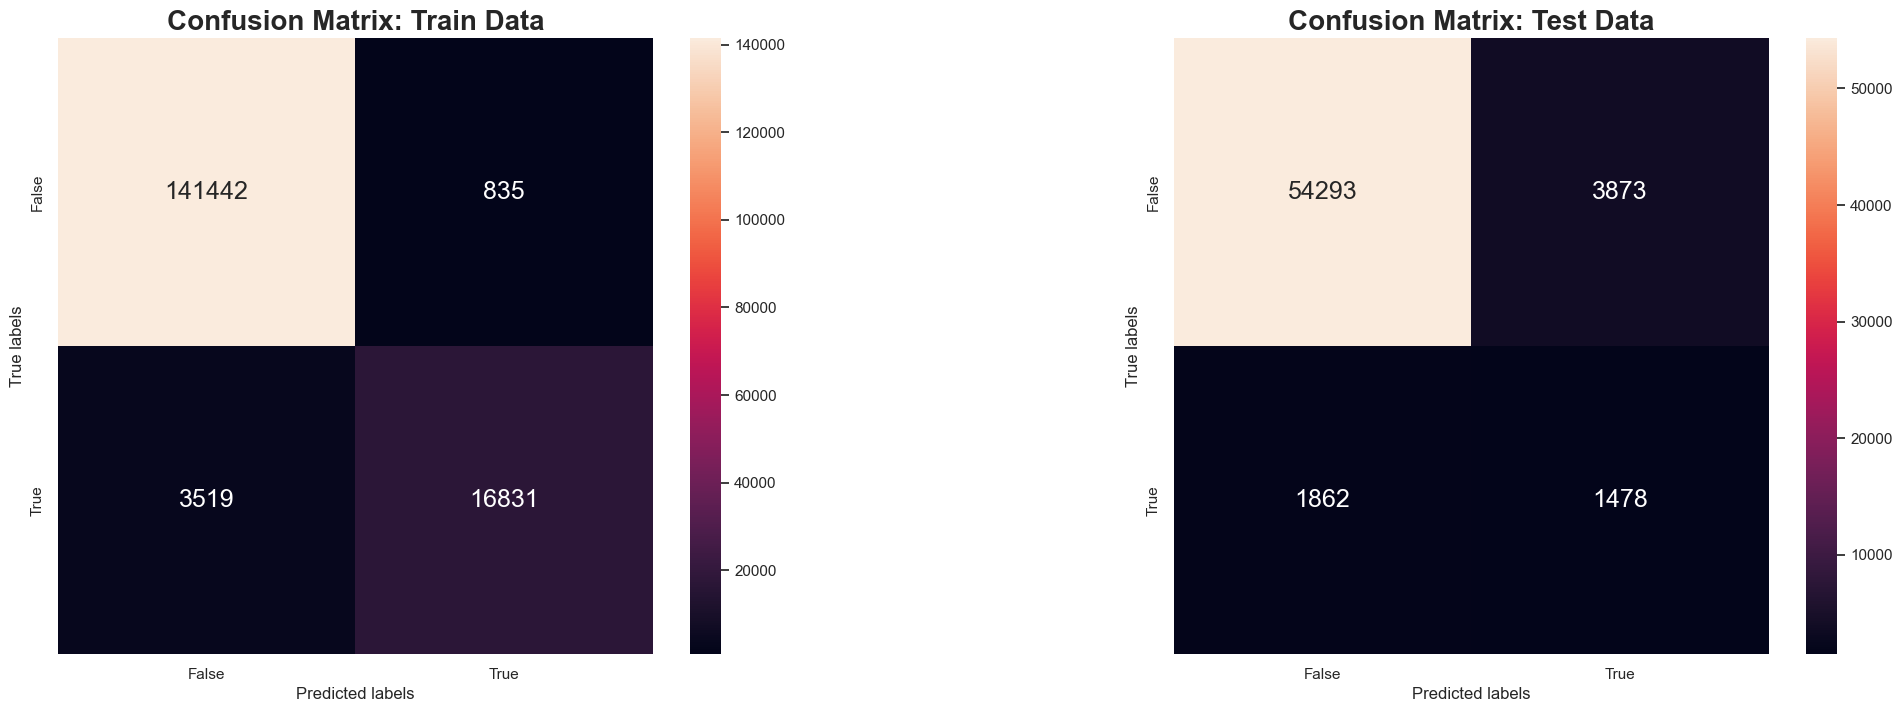

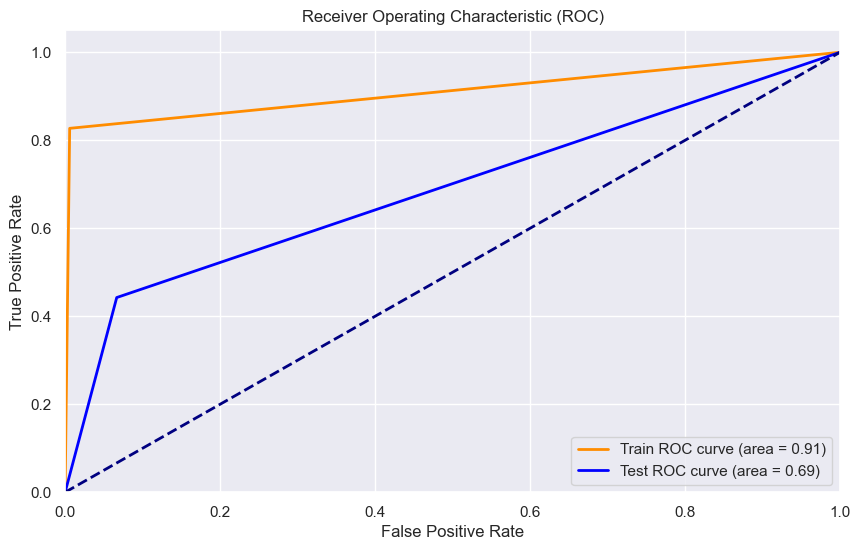

In [170]:
random_forest_classifier = train_model(x_train, y_train, RandomForestClassifier(n_estimators=10))
evaluate_model(x_train, x_test, y_train, y_test, random_forest_classifier, 5)

# Logistic Regression (Resampled)

Train accuracy :  0.9430906307070782
Train MSE:  0.05690936929292184 

Test accuracy :  0.9350469872857933
Test MSE:  0.06495301271420674 

Number of folds:  5
Accuracy score (Cross Validated): 0.9431213619065133
Standard Deviation (Cross Validated):  0.0022238620043453687 

TPR Train :	 0.6116953316953317
TNR Train :	 0.9904903814390239
FPR Train :	 0.009509618560976124
FNR Train :	 0.3883046683046683 

TPR Test :	 0.5413173652694611
TNR Test :	 0.9576556751366778
FPR Test :	 0.042344324863322215
FNR Test :	 0.45868263473053894 

Acc :  0.9350469872857933
Precision :	 0.4233200655584172
Recall :	 0.5413173652694611
F1 score :	 0.47510182630403364


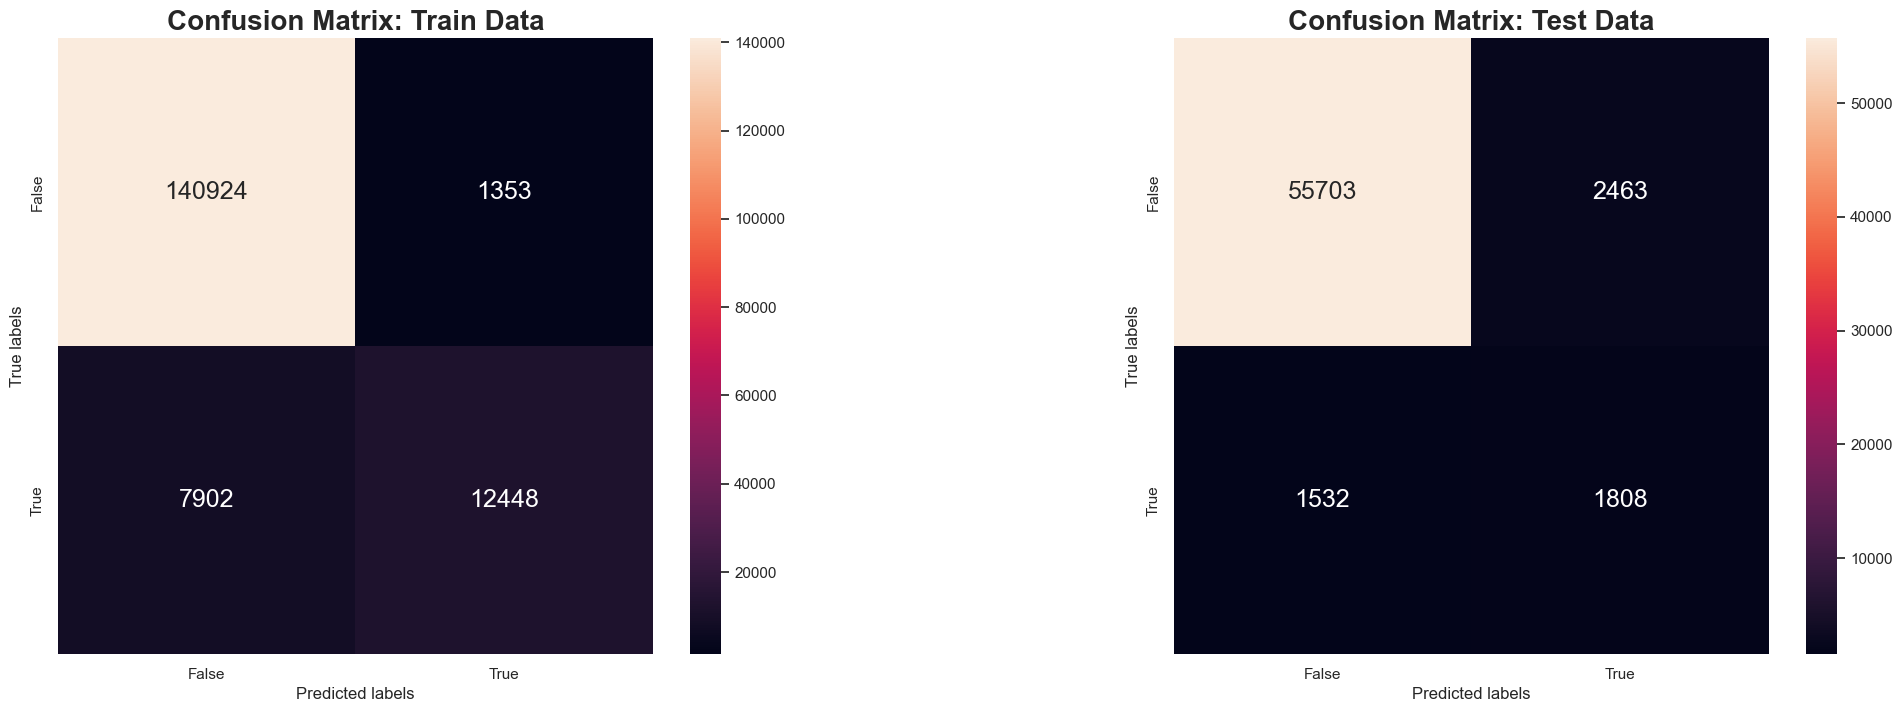

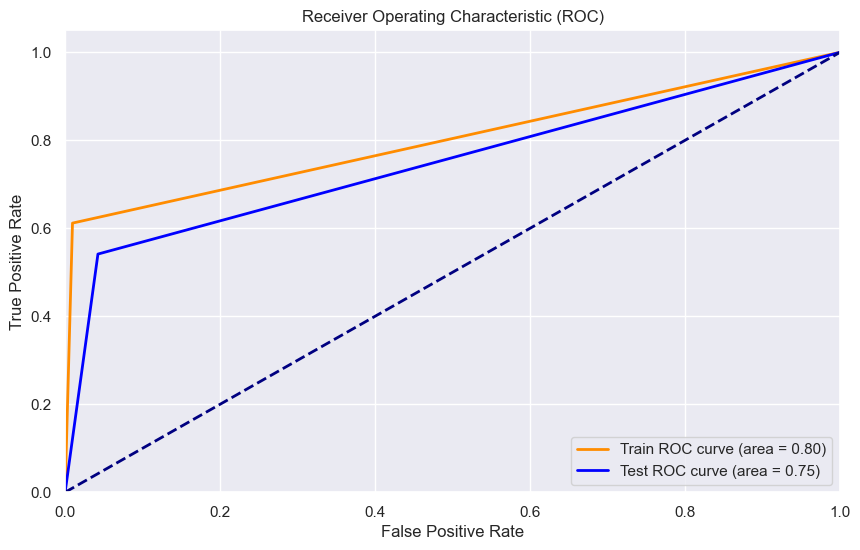

In [171]:
logistic_regression_classifier = train_model(x_train, y_train, LogisticRegression())
evaluate_model(x_train, x_test, y_train, y_test, logistic_regression_classifier, 5)

# Discussion about results

## Between the two sampled datasets
It is obvious and clear that the SMOTEENN sampled dataset performs a lot better. We suspect it is due to these a few reasons.

- If we simply just under sample, we remove a lot of data from the dataset. There is too much information lost that are important when training, concretely, we would have lost 200,000 rows that play a significant role in telling us that someone **does not** have heart disease.
- Instead, when we use SMOTEENN, which over samples and under samples, we get the benefit of both over sampling and under sampling.
- This instead means that we do not have much loss of information as we are not throwing much data away. We find that this mixture of over sampling and under sampling using SMOTEENN is fits the problem the best.

There are a few metrics in the above models that we want to take note of. 

Firstly, the most obvious metric would to consider would be the accuracy. We tried to be as verbose as possible in our training. We first look at train and test accuracy, then we use cross validation to check the edge case that the variance caused certain models to perform better. In this regard, the DecisionTreeClassifier, while not always having the best cross validation accuracy, has the best testing accuracy.

Secondly, we want to look at the **Precision**, **Recall** and **F1** accuracy metrics. Going back to our problem, we want to predict the risk that someone will develop a **Heart Attack** based on their medical history. As recall is the measure of how many **True positives** against the whole **Positive** class (HadHeartAttack) a higher recall will be preferred as it means that our model can have a high accuracy of predicting when someone will have a heart attack. In short, we want to reduce the number of false negatives as it would miss a person possibly having a heart attack. In this case, when comparing between the precision, recall and F1 score, we see that the DecisionTreeClassifier is still the most consistent. It is able to achieve the best results as compared to the RandomForest or the LogisticRegression classifier.

Based on these two evaluation criterias, we will be using the DecisionTree classifier moving forward, as it performs the best in this problem space with the following properties:
1) Highest cross-validated accuracy
2) Highest Precision, Recall and F1 accuracy => best performance in classification

# Fine tuning the model for better results

Now that we have established that the DecisionTree classifier is the best, we want to try to further optimize this model. We can do this with by tuning it's hyperparameters. We opted for a random search as this cuts down on compute time.

In [174]:
# Define the parameter grid for Random Forest
param_grid = {
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini'],
}

# Create a Decision Tree Classifier
classifier = DecisionTreeClassifier()

# Randomized Search Cross Validation
random_search = RandomizedSearchCV(estimator=classifier, 
                                      param_distributions=param_grid, 
                                      n_iter=100,  # Number of parameter settings that are sampled
                                      cv=5,  # Number of folds in cross-validation
                                      verbose=0, # Don't clutter out the output 
                                      random_state=150, # Any random number, so that the result is reproducible
                                      n_jobs=-1)  # Use all processors

# Fit the random search model
random_search.fit(x_train, y_train)

# Best parameters found
print("Best Parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

best_rf_model = random_search.best_estimator_
best_params = random_search.best_params_

Best Parameters: {'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'gini'}
Best score: 0.9717758954782605


After searching and checking for what the best parameters, we evaluate it the same way we did for our base classifier.

Train accuracy :  0.9732639721571449
Train MSE:  0.02673602784285512 

Test accuracy :  0.910821708451208
Test MSE:  0.08917829154879199 

Number of folds:  5
Accuracy score (Cross Validated): 0.9717697465512483
Standard Deviation (Cross Validated):  0.001289483640114644 

TPR Train :	 0.8247665847665848
TNR Train :	 0.9945036794422148
FPR Train :	 0.005496320557785165
FNR Train :	 0.17523341523341524 

TPR Test :	 0.2868263473053892
TNR Test :	 0.9466526836983805
FPR Test :	 0.053347316301619506
FNR Test :	 0.7131736526946107 

Acc :  0.910821708451208
Precision :	 0.23590248707214972
Recall :	 0.2868263473053892
F1 score :	 0.25888393460343195


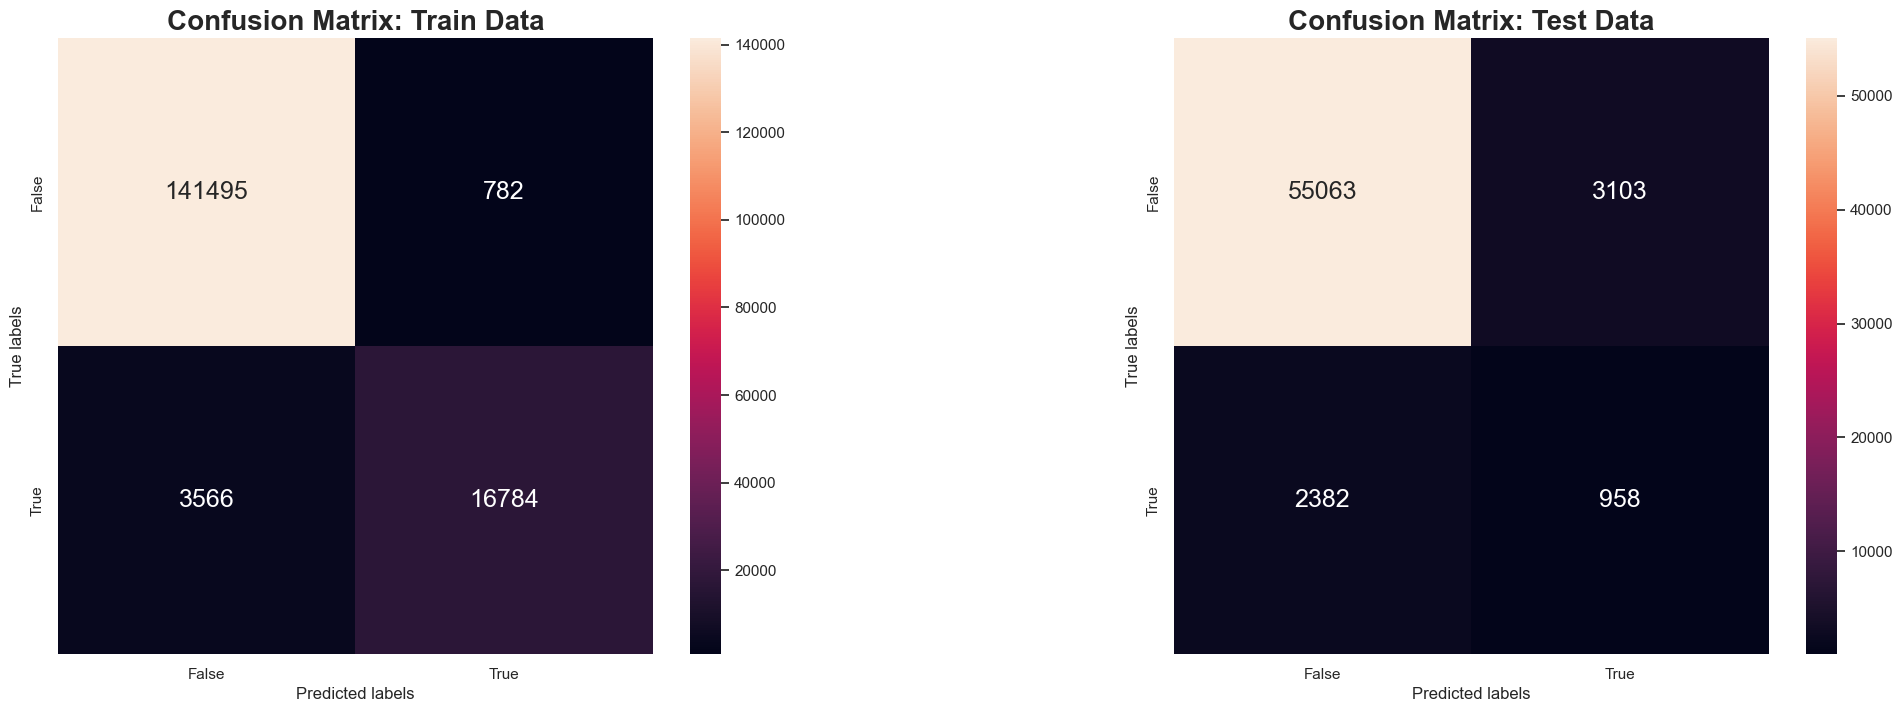

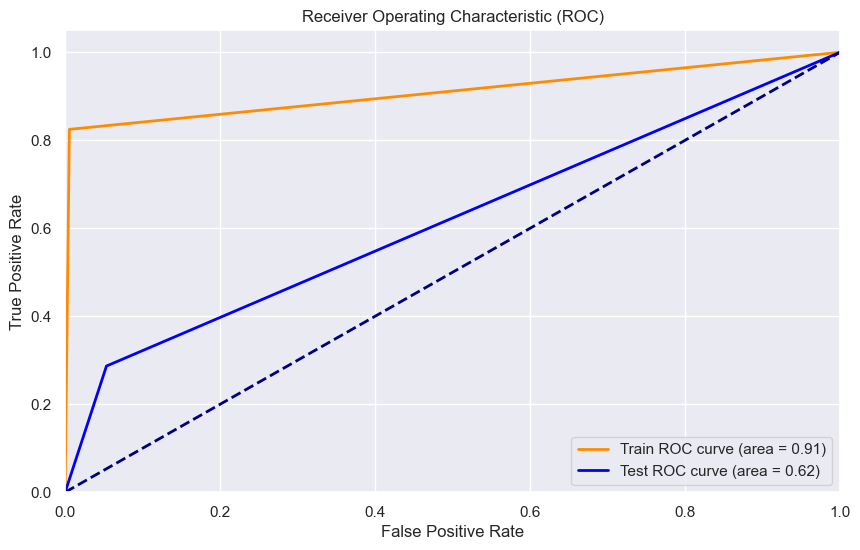

In [175]:
best_classifier = train_model(x_train, y_train, DecisionTreeClassifier(**best_params))
# evaluate_model(x_train, x_test, y_train, y_test, x_original, y_original, best_random_forest_classifier, 5)
evaluate_model(x_train, x_test, y_train, y_test, best_classifier, 5)

In this instance, we see that hyperparameter tuning did not produce a better model in when testing or checking for the precision/recall/f1 scores. We believe that this is because the hyperparameter tuner tunes for the highest test accuracy. A high train accuracy does not imply a high test accuracy.

# Conclusion
### Data Cleaning and EDA
The initial data cleaning process involved checking for null values and odd values within the dataset. Fortunately, there were no null values detected, but some categorical features had unusual options. After evaluating their significance, it was determined that some features, such as "HadDiabetes" and "CovidPos", were not significant and could be dropped. Additionally, class imbalance was observed in the target variable "HadHeartAttack", which was addressed by downsampling the majority class. Numerical and categorical data were analyzed separately to identify meaningful features for predicting heart disease. While numerical features did not show distinct patterns, some categorical variables exhibited significant relationships with the target variable, such as "AgeCategory" and "HadAngina".

### Data Preparation
The dataset was prepared for modeling by encoding boolean and categorical variables appropriately. Ordinal encoding was used for categorical features with hierarchical relationships, while one-hot encoding was applied to others.

### Feature Selection
Feature selection was performed to identify the most relevant predictors of heart disease. Both chi-square tests and visual inspections highlighted the importance of certain features, such as "HadAngina", "HadStroke".

### Modeling
Three machine learning models - Decision Tree, Random Forest, and Logistic Regression - were trained on the dataset. Initial results showed promising accuracy, but concerns were raised due to class imbalance. Therefore, models were retrained using a SMOTEENN resampled dataset to address this issue.

### Model Evaluation
The performance of each model was evaluated based on accuracy, precision, recall, and F1 score. Random Forest consistently outperformed the other models in terms of recall, indicating its ability to correctly identify instances of heart disease. Hyperparameter tuning was attempted to optimize model performance further, but minimal improvements were observed.

In conclusion, the DecisionTree classifier trained on the resampled dataset emerged as the most effective model for predicting heart disease. Despite challenges such as class imbalance, the model demonstrated strong performance in identifying individuals at risk of heart attacks. Moving forward, further research could focus on refining the model architecture or exploring alternative resampling techniques to improve overall accuracy and robustness.